# **ACCT 745 Midterm Project: Accounts Receivables Provision**
## **Documented Workflow for Python Scripts**
## **Author:** *Long Dang*

## ***I. Data Inspection & Dictionary Creation***

### **1. Setup & Imports**
#### - Imports core libraries
#### - Sets display options for cleaner tables in Jupyter
#### - Defines your Windows base path (edit if your folder changes)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
from IPython.display import display, Markdown

# Pretty display in Jupyter
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 30)

# Use the current working directory (project root / notebook folder)
BASE_DIR = Path(".")

# Filenames only (no absolute paths needed)
FILES = {
    "provisions": "provisions for acct receivables.csv",
    "industry_data": "industry_data.csv",
    "industry_names": "industry names.csv",
}

def section(title: str, subtitle: str = ""):
    """Helper to render a nice section header in Jupyter."""
    display(Markdown(f"## {title}"))
    if subtitle:
        display(Markdown(subtitle))

### **2. Robust CSV Loader**
#### - Reads CSVs using a few common encodings
#### - Raises a clear error if a file is missing

In [3]:
import re

def _normalize_name(s: str) -> str:
    """Lowercase + remove spaces/underscores/dashes for matching."""
    return re.sub(r"[\s_\-]+", "", s).lower()

def find_file(filename: str, base: Path = BASE_DIR) -> Path:
    """
    Try exact path first; otherwise search the project tree for a close match.
    Priority: exact name -> normalized exact -> normalized contains.
    """
    cand = base / filename
    if cand.exists():
        return cand

    target_norm = _normalize_name(filename)
    # Build an index of CSVs (one pass)
    csv_paths = list(base.rglob("*.csv"))

    # 1) exact filename (case-insensitive) in same folder tree
    for p in csv_paths:
        if p.name.lower() == filename.lower():
            return p

    # 2) normalized exact match
    for p in csv_paths:
        if _normalize_name(p.name) == target_norm:
            return p

    # 3) normalized contains (last resort)
    for p in csv_paths:
        if target_norm in _normalize_name(p.name):
            return p

    raise FileNotFoundError(f"Could not locate '{filename}' under {base.resolve()}")

def safe_read_csv(path: Path) -> pd.DataFrame:
    """Robust CSV reader with common encodings."""
    for enc in ("utf-8-sig", "utf-8", "cp1252", "latin-1"):
        try:
            return pd.read_csv(path, low_memory=False, encoding=enc)
        except UnicodeDecodeError:
            continue
    # Final attempt without explicit encoding
    return pd.read_csv(path, low_memory=False)

### **3. Load Datasets & Basic Shape Check**
#### - Loads all three datasets
#### - Shows row/column counts so you know what you’re working with

In [5]:
section("Load datasets", "Locate files in the project and verify shapes.")

prov_path = find_file(FILES["provisions"])
indd_path = find_file(FILES["industry_data"])
indn_path = find_file(FILES["industry_names"])

display(Markdown("**Resolved paths**"))
display(pd.DataFrame({
    "name": ["provisions", "industry_data", "industry_names"],
    "path": [str(prov_path), str(indd_path), str(indn_path)]
}))

provisions    = safe_read_csv(prov_path)
industry_data = safe_read_csv(indd_path)
industry_names= safe_read_csv(indn_path)

shape_tbl = pd.DataFrame({
    "table": ["provisions", "industry_data", "industry_names"],
    "rows":  [provisions.shape[0], industry_data.shape[0], industry_names.shape[0]],
    "cols":  [provisions.shape[1], industry_data.shape[1], industry_names.shape[1]],
})
display(shape_tbl)

## Load datasets

Locate files in the project and verify shapes.

**Resolved paths**

,name,path
0,provisions,(1) Accounts Receivables Provision Data\provis...
1,industry_data,(1) Accounts Receivables Provision Data\indust...
2,industry_names,(1) Accounts Receivables Provision Data\indust...


,table,rows,cols
0,provisions,323475,27
1,industry_data,47767,2
2,industry_names,46,2


### **4. Columns & Dtype Preview**
#### - Lists columns and pandas dtypes for each dataset

In [8]:
section("Columns & dtypes — quick peek")

def cols_dtypes(df: pd.DataFrame, name: str):
    out = pd.DataFrame({"column": df.columns, "dtype": [str(t) for t in df.dtypes]})
    display(Markdown(f"**{name}**")); display(out)

cols_dtypes(provisions, "provisions")
cols_dtypes(industry_data, "industry_data")
cols_dtypes(industry_names, "industry_names")

## Columns & dtypes — quick peek

**provisions**

,column,dtype
0,company_code,int64
1,date_var,object
2,sales,float64
3,interest_expense,float64
4,provision_bad_receivables,float64
5,writeoff_bad_receivables,float64
6,cogs,float64
7,net_income,float64
8,ebidta,float64
9,ebit,float64


**industry_data**

,column,dtype
0,new_industry_code,int64
1,company_id,int64


**industry_names**

,column,dtype
0,Industry Name,object
1,Industry code,int64


### **5. Parse Dates & Quick Date Profile**
#### - Parses 'date_var' → 'date', adds 'year'/'quarter'
#### - Shows reporting month distribution (e.g., Dec vs Jun)

In [9]:
section("Date parsing & distribution")

def parse_stata_like_date(val):
    if pd.isna(val): return pd.NaT
    s = str(val).strip().lower()
    m = re.match(r"^(\d{1,2})([a-z]{3})(\d{4})$", s)
    if not m: return pd.NaT
    day, mon, year = m.groups()
    try:
        return pd.to_datetime(f"{day}-{mon}-{year}", format="%d-%b-%Y")
    except Exception:
        return pd.NaT

if "date_var" in provisions.columns:
    provisions["date"] = provisions["date_var"].map(parse_stata_like_date)
    provisions["year"] = provisions["date"].dt.year
    provisions["quarter"] = provisions["date"].dt.quarter

    display(provisions[["date_var","date","year","quarter"]].head(8))

    month_share = provisions["date"].dt.month.value_counts(normalize=True).sort_index() * 100
    display(Markdown("**Month distribution of reporting dates (% of rows):**"))
    display(month_share.rename("percent").round(2).to_frame())
else:
    display(Markdown("> `date_var` not found in provisions — skip parsing."))

## Date parsing & distribution

,date_var,date,year,quarter
0,31dec2012,2012-12-31,2012,4
1,31dec2013,2013-12-31,2013,4
2,31dec2014,2014-12-31,2014,4
3,31dec2015,2015-12-31,2015,4
4,31dec2016,2016-12-31,2016,4
5,31dec2017,2017-12-31,2017,4
6,31dec2018,2018-12-31,2018,4
7,31dec2019,2019-12-31,2019,4


**Month distribution of reporting dates (% of rows):**

,percent
date,
6,1.17
12,98.83


### **6. Duplicate Check at the Grain**
#### - Detects duplicates at (company_code, date) grain

In [10]:
section("Duplicate check at (company_code, date)")

if {"company_code","date"}.issubset(provisions.columns):
    dup_mask = provisions.duplicated(subset=["company_code","date"], keep=False)
    n_dupe_rows = int(dup_mask.sum())
    dupe_pairs = provisions.loc[dup_mask, ["company_code","date"]].drop_duplicates()

    display(pd.DataFrame({
        "duplicate_rows": [n_dupe_rows],
        "duplicate_pairs": [dupe_pairs.shape[0]],
    }))

    if n_dupe_rows:
        display(Markdown("**Sample duplicated pairs:**"))
        display(dupe_pairs.sort_values(["company_code","date"]).head(12))
else:
    display(Markdown("> Keys `company_code` and/or `date` not available yet."))

## Duplicate check at (company_code, date)

,duplicate_rows,duplicate_pairs
0,12,6


**Sample duplicated pairs:**

,company_code,date
21152,139618,2016-06-30
21157,139618,2021-06-30
93963,271367,2014-06-30
113706,313707,2019-06-30
175703,471018,2013-06-30
290797,656899,2014-06-30


### **7. AR-Related Columns (sanity)**
#### - Enumerates receivables / aging / provisioning columns

In [11]:
section("AR-related columns (provisions)")
ar_cols = [c for c in provisions.columns if ("receivable" in c.lower()) or c.lower().startswith("accounts_receivables")]
display(pd.DataFrame({"ar_related_columns": ar_cols}))

## AR-related columns (provisions)

,ar_related_columns
0,provision_bad_receivables
1,writeoff_bad_receivables
2,accounts_receivables
3,receivables_morethan6m
4,secured_receivables_morethan6m
5,unsec_receivables_morethan6m
6,receivables_lessthan6m
7,secured_receivables_lessthan6m
8,unsec_receivables_lessthan6m


### **8. Data Dictionaries (all tables)**
#### - Shows dtype, missingness, # uniques, and example values
#### - Sorted by % missing to surface issues quickly

In [12]:
section("Data dictionaries (inspection-first view)",
        "Sorted by % missing (highest first). Adjust `max_rows_to_show` if you want more/less.")

def build_data_dictionary(df: pd.DataFrame, table_name: str) -> pd.DataFrame:
    d = pd.DataFrame({
        "table": table_name,
        "column": df.columns,
        "dtype_inferred": [str(t) for t in df.dtypes],
        "n_non_null": df.notna().sum().values,
        "n_null": df.isna().sum().values,
        "pct_missing": (df.isna().mean().values * 100).round(2),
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
    })
    examples = []
    for c in df.columns:
        vals = df[c].dropna().head(3).tolist()
        examples.append(", ".join(map(lambda x: str(x)[:60], vals)))
    d["examples"] = examples
    return d.sort_values("pct_missing", ascending=False).reset_index(drop=True)

max_rows_to_show = 30

dict_prov = build_data_dictionary(provisions, "provisions")
dict_indd = build_data_dictionary(industry_data, "industry_data")
dict_indn = build_data_dictionary(industry_names, "industry_names")

display(Markdown("**provisions — top rows by % missing:**"))
display(dict_prov.head(max_rows_to_show))

display(Markdown("**industry_data — all columns:**"))
display(dict_indd)

display(Markdown("**industry_names — all columns:**"))
display(dict_indn)

## Data dictionaries (inspection-first view)

Sorted by % missing (highest first). Adjust `max_rows_to_show` if you want more/less.

**provisions — top rows by % missing:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,provisions,secured_receivables_morethan6m,float64,4320,319155,98.66,2082,"1.544, 0.0478, 0.0213"
1,provisions,secured_receivables_lessthan6m,float64,9531,313944,97.05,5996,"1.3731, 1.362, 1.3499"
2,provisions,provision_bad_receivables,float64,34577,288898,89.31,8102,"0.0901, 0.0574, 0.0608"
3,provisions,writeoff_bad_receivables,float64,41433,282042,87.19,5578,"0.0074, 0.0016, 0.0016"
4,provisions,unsec_receivables_morethan6m,float64,113828,209647,64.81,21129,"0.0386, 0.0426, 0.04"
5,provisions,receivables_morethan6m,float64,114561,208914,64.58,21360,"0.0386, 0.0426, 0.04"
6,provisions,investment_asset,float64,160944,162531,50.25,51451,"0.2106, 1.1323, 1.1145"
7,provisions,unsec_receivables_lessthan6m,float64,171457,152018,47.00,50624,"0.7392, 0.4154, 0.4966"
8,provisions,receivables_lessthan6m,float64,173419,150056,46.39,51516,"0.7392, 0.4154, 0.4966"
9,provisions,inventories,float64,205738,117737,36.40,70456,"9.5523, 8.1464, 9.4798"


**industry_data — all columns:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,industry_data,new_industry_code,int64,47767,0,0.0,44,"101, 101, 101"
1,industry_data,company_id,int64,47767,0,0.0,47767,"173839, 400434, 766803"


**industry_names — all columns:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,industry_names,Industry Name,object,46,0,0.0,46,"Agriculture, Mining, quarrying, and extraction..."
1,industry_names,Industry code,int64,46,0,0.0,44,"101, 102, 103"


### **9. Numeric Summary (provisions)**
#### - Descriptive stats for numeric columns (incl. extreme percentiles)

In [13]:
section("Numeric summary — provisions (selected percentiles)")

num_cols = provisions.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    describe_tbl = provisions[num_cols].describe(
        percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    ).T
    display(describe_tbl)
else:
    display(Markdown("> No numeric columns detected in `provisions`."))

## Numeric summary — provisions (selected percentiles)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
company_code,323475.0,406680.623442,178084.926057,100003.0000,107065.000000,131820.000000,245665.5000,436767.0000,528016.000000,672783.000000,747940.000000,792720.0000
sales,252550.0,79.198587,864.674015,-11.3747,0.002700,0.019200,0.9191,6.7952,31.005375,222.079580,1103.306178,97142.1480
interest_expense,213795.0,3.581586,30.391607,-68.4728,0.001300,0.002000,0.0334,0.2045,0.967200,9.941890,61.093998,3994.9006
provision_bad_receivables,34577.0,1.403610,15.918423,-0.1063,0.000000,0.001300,0.0165,0.0740,0.326700,3.381980,21.547020,1684.4496
writeoff_bad_receivables,41433.0,0.465888,5.825427,-0.0131,0.000000,0.000000,0.0052,0.0230,0.103000,0.992800,6.630348,578.5004
cogs,323475.0,47.767087,614.598849,-887.7171,0.000000,0.000000,0.0387,1.8797,14.748400,133.686847,682.911453,77870.7970
net_income,304678.0,1.953486,72.107962,-9836.0204,-31.583529,-3.354130,-0.0161,0.0320,0.575600,9.314095,57.215990,5286.3800
ebidta,304844.0,9.522388,118.242600,-5906.4676,-7.032971,-0.379200,0.0067,0.3240,2.431700,25.851675,149.407940,11788.6076
ebit,304844.0,6.333430,92.844338,-6291.3059,-14.964783,-1.199240,0.0000,0.1803,1.665100,19.017055,111.053969,8239.0837
debt_total,250309.0,41.490930,399.517366,-201.5009,0.002000,0.016400,0.3691,2.2175,10.579500,110.580720,656.865000,44151.8237


### **10. What we learned & next step** 
#### - Summarizes this inspection pass
#### - Points to the cleaning/summary step next

In [14]:
summary_bullets = """
- **Files located** via `find_file()` and loaded from the current project (no absolute paths).
- **Dates parsed** into `date`, `year`, `quarter`; month distribution reviewed.
- **Duplicates** at (company_code, date) identified for resolution in cleaning.
- **AR fields** confirmed (total, >6m, <6m, secured/unsecured, provisions, write-offs).
- **Data dictionaries** surfaced inline for all tables; **numeric ranges** reviewed.
**Next:** run the Cleaning & Statistics Summary notebook cells to deduplicate, join industry, and compute AR metrics/flags.
"""
section("Inspection summary", summary_bullets)

## Inspection summary


- **Files located** via `find_file()` and loaded from the current project (no absolute paths).
- **Dates parsed** into `date`, `year`, `quarter`; month distribution reviewed.
- **Duplicates** at (company_code, date) identified for resolution in cleaning.
- **AR fields** confirmed (total, >6m, <6m, secured/unsecured, provisions, write-offs).
- **Data dictionaries** surfaced inline for all tables; **numeric ranges** reviewed.
**Next:** run the Cleaning & Statistics Summary notebook cells to deduplicate, join industry, and compute AR metrics/flags.


## ***II. Data Cleaning***

### **1. Load datasets**
#### - Loads the three CSVs with a robust reader
#### - Displays shapes so you can verify inputs

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
from IPython.display import display, Markdown
from difflib import get_close_matches

def _normalize_name(s: str) -> str:
    """Lowercase + strip spaces/underscores/dashes for resilient matching."""
    return re.sub(r"[\s_\-]+", "", s).lower()

def find_file(filename: str, base: Path = BASE_DIR) -> Path:
    """
    Try to find 'filename' anywhere under 'base' (recursively).
    Matching priority:
      1) Exact name (case-insensitive)
      2) Normalized exact (remove spaces/_/-)
      3) Normalized contains
      4) Fuzzy best match (using difflib) — last resort
    """
    # Exact relative path first
    direct = base / filename
    if direct.exists():
        return direct

    target_norm = _normalize_name(filename)
    csvs = list(base.rglob("*.csv"))
    names = [p.name for p in csvs]
    norms = [_normalize_name(n) for n in names]

    # 1) exact (case-insensitive)
    for p in csvs:
        if p.name.lower() == filename.lower():
            return p
    # 2) normalized exact
    for p, nrm in zip(csvs, norms):
        if nrm == target_norm:
            return p
    # 3) normalized contains
    for p, nrm in zip(csvs, norms):
        if target_norm in nrm:
            return p
    # 4) fuzzy best match
    if norms:
        match = get_close_matches(target_norm, norms, n=1, cutoff=0.6)
        if match:
            idx = norms.index(match[0])
            guess = csvs[idx]
            display(Markdown(f"> ⚠️ Couldn’t find **{filename}** exactly. Using closest match: **{guess.name}**"))
            return guess

    # If we reach here, surface a helpful error
    raise FileNotFoundError(
        f"Could not locate '{filename}' under {base.resolve()}. "
        f"CSV files found: {', '.join(names[:20])}{' ...' if len(names)>20 else ''}"
    )

def safe_read_csv(path: Path) -> pd.DataFrame:
    """Robust CSV reader with common encodings."""
    for enc in ("utf-8-sig", "utf-8", "cp1252", "latin-1"):
        try:
            return pd.read_csv(path, low_memory=False, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, low_memory=False)

# Locate files in the project (using FILES from Cell 1)
prov_path = find_file(FILES["provisions"], BASE_DIR)
indd_path = find_file(FILES["industry_data"], BASE_DIR)
indn_path = find_file(FILES["industry_names"], BASE_DIR)

display(Markdown("**Resolved paths**"))
display(pd.DataFrame({
    "name": ["provisions", "industry_data", "industry_names"],
    "path": [str(prov_path), str(indd_path), str(indn_path)]
}))

# Load
provisions     = safe_read_csv(prov_path)
industry_data  = safe_read_csv(indd_path)
industry_names = safe_read_csv(indn_path)

display(Markdown("**Loaded tables (rows × cols):**"))
display(pd.DataFrame({
    "table": ["provisions","industry_data","industry_names"],
    "shape": [f"{provisions.shape[0]} × {provisions.shape[1]}",
              f"{industry_data.shape[0]} × {industry_data.shape[1]}",
              f"{industry_names.shape[0]} × {industry_names.shape[1]}"]
}))

**Resolved paths**

,name,path
0,provisions,(1) Accounts Receivables Provision Data\provis...
1,industry_data,(1) Accounts Receivables Provision Data\indust...
2,industry_names,(1) Accounts Receivables Provision Data\indust...


**Loaded tables (rows × cols):**

,table,shape
0,provisions,323475 × 27
1,industry_data,47767 × 2
2,industry_names,46 × 2


### **2. Parse dates & basic type hygiene**
#### - Parses 'date_var' like '31dec2019' → datetime 'date'
#### - Adds 'year' and 'quarter'
#### - Leaves original columns intact (non-destructive)

In [17]:
import re

def parse_stata_like_date(val):
    if pd.isna(val): return pd.NaT
    s = str(val).strip().lower()
    m = re.match(r"^(\d{1,2})([a-z]{3})(\d{4})$", s)
    if not m: return pd.NaT
    day, mon, year = m.groups()
    try:
        return pd.to_datetime(f"{day}-{mon}-{year}", format="%d-%b-%Y")
    except Exception:
        return pd.NaT

prov = provisions.copy()
if "date_var" in prov.columns:
    prov["date"] = prov["date_var"].map(parse_stata_like_date)
    prov["year"] = prov["date"].dt.year
    prov["quarter"] = prov["date"].dt.quarter

display(Markdown("**Date fields preview:**"))
display(prov[["date_var","date","year","quarter"]].head(8))

**Date fields preview:**

,date_var,date,year,quarter
0,31dec2012,2012-12-31,2012,4
1,31dec2013,2013-12-31,2013,4
2,31dec2014,2014-12-31,2014,4
3,31dec2015,2015-12-31,2015,4
4,31dec2016,2016-12-31,2016,4
5,31dec2017,2017-12-31,2017,4
6,31dec2018,2018-12-31,2018,4
7,31dec2019,2019-12-31,2019,4


### **3. De-duplicate at the analytic grain (company_code × date)**
#### - Detects duplicates at (company_code, date)
#### - Keeps the row with: (1) more non-null AR fields, (2) higher sales, (3) first otherwise
#### - Shows before/after counts and a small sample of the resolved duplicates

In [18]:
AR_FIELDS = [
    "accounts_receivables",
    "receivables_morethan6m",
    "secured_receivables_morethan6m",
    "unsec_receivables_morethan6m",
    "receivables_lessthan6m",
    "secured_receivables_lessthan6m",
    "unsec_receivables_lessthan6m",
    "provision_bad_receivables",
    "writeoff_bad_receivables",
]

# Ensure AR fields exist (create as NA if not found to avoid KeyErrors)
for c in AR_FIELDS:
    if c not in prov.columns:
        prov[c] = np.nan

before_dupes = int(prov.duplicated(subset=["company_code","date"], keep=False).sum())

# Score rows for tie-breaking (vectorized)
prov["_nn_ar"]        = prov[AR_FIELDS].notna().sum(axis=1)
prov["_sales_tiebkr"] = pd.to_numeric(prov.get("sales"), errors="coerce").fillna(-np.inf)

# Sort so the "best" record per key comes first
prov_sorted = prov.sort_values(
    ["company_code","date","_nn_ar","_sales_tiebkr"],
    ascending=[True, True, False, False]
)
prov_clean = prov_sorted.drop_duplicates(subset=["company_code","date"], keep="first").copy()
after_dupes = int(prov_clean.duplicated(subset=["company_code","date"], keep=False).sum())

display(Markdown("**Duplicate status at (company_code, date):**"))
display(pd.DataFrame({"before_dupe_rows":[before_dupes], "after_dupe_rows":[after_dupes]}))

# Optional: show a small sample of keys that had duplicates
if before_dupes > 0:
    dkeys = prov.loc[prov.duplicated(subset=["company_code","date"], keep=False),
                     ["company_code","date"]].drop_duplicates().head(6)
    display(Markdown("**Sample duplicate keys (resolved):**"))
    display(dkeys.sort_values(["company_code","date"]))
    
# Clean up helper columns
prov_clean.drop(columns=["_nn_ar","_sales_tiebkr"], inplace=True, errors="ignore")

**Duplicate status at (company_code, date):**

,before_dupe_rows,after_dupe_rows
0,12,0


**Sample duplicate keys (resolved):**

,company_code,date
21152,139618,2016-06-30
21157,139618,2021-06-30
93963,271367,2014-06-30
113706,313707,2019-06-30
175703,471018,2013-06-30
290797,656899,2014-06-30


### **4. Standardize industry tables**
#### - Renames keys for consistency
#### - Ensures integer dtypes for codes
#### - Dedupes any repeated industry_code labels (keep first)
#### - Displays quick sanity checks

In [19]:
ind_data = industry_data.rename(columns={
    "new_industry_code":"industry_code",
    "company_id":"company_code"
}).copy()

ind_names = industry_names.rename(columns={
    "Industry code":"industry_code",
    "Industry Name":"industry_name"
}).copy()

# Nullable integers to tolerate missing codes while preserving int semantics
ind_data["company_code"] = ind_data["company_code"].astype("Int64")
ind_data["industry_code"] = ind_data["industry_code"].astype("Int64")
ind_names["industry_code"] = ind_names["industry_code"].astype("Int64")

# Deduplicate any repeated industry_code labels (keep first as canonical)
before_names = ind_names.shape[0]
ind_names = ind_names.drop_duplicates(subset=["industry_code"], keep="first").copy()
after_names = ind_names.shape[0]

display(Markdown("**Industry table checks:**"))
display(pd.DataFrame({
    "ind_data_rows":[ind_data.shape[0]],
    "ind_data_unique_companies":[ind_data["company_code"].nunique()],
    "ind_names_rows_before":[before_names],
    "ind_names_rows_after":[after_names]
}))

**Industry table checks:**

,ind_data_rows,ind_data_unique_companies,ind_names_rows_before,ind_names_rows_after
0,47767,47767,46,44


### **5. Merge to a clean analytic fact table**
#### - Left-joins provisions → industry_code → industry_name
#### - Preserves all rows from the deduplicated provisions
#### - Displays merge health metrics

In [20]:
fact = (prov_clean
        .merge(ind_data,  on="company_code", how="left", validate="many_to_one")
        .merge(ind_names, on="industry_code", how="left", validate="many_to_one"))

display(Markdown("**Merge health:**"))
display(pd.DataFrame({
    "rows_fact":[fact.shape[0]],
    "companies":[fact["company_code"].nunique()],
    "years_min":[int(fact["year"].min())],
    "years_max":[int(fact["year"].max())],
    "pct_dec31":[(fact["date"].dt.month.eq(12)).mean()*100],
    "pct_jun30":[(fact["date"].dt.month.eq(6)).mean()*100],
}).round(2))

**Merge health:**

,rows_fact,companies,years_min,years_max,pct_dec31,pct_jun30
0,323469,39168,2012,2022,98.83,1.17


### **6. Compute accounting metrics & diagnostic flags**
#### - Adds AR Turnover, DSO (approx), provision/write-off rates
#### - Adds liquidity (current ratio) and leverage (debt/assets)
#### - Flags NI>0 & CFO<0
#### - Validates AR composition: (>6m + <6m) ~ total AR (within 1% tolerance)
#### - Replaces ±inf with NaN to keep summaries clean

In [21]:
def nz_div(num, den):
    out = num / den
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

fact["ar_turnover"]        = nz_div(fact["sales"], fact["accounts_receivables"])
fact["dso_approx"]         = nz_div(365 * fact["accounts_receivables"], fact["sales"])
fact["prov_rate"]          = nz_div(fact["provision_bad_receivables"], fact["accounts_receivables"])
fact["writeoff_rate"]      = nz_div(fact["writeoff_bad_receivables"], fact["accounts_receivables"])
fact["liq_current_ratio"]  = nz_div(fact["current_asset"], fact["current_liabilities"])
fact["lev_debt_to_assets"] = nz_div(fact["debt_total"], fact["total_asset"])

fact["ni_pos_cfo_neg_flag"] = np.where(
    (pd.to_numeric(fact["net_income"], errors="coerce") > 0) &
    (pd.to_numeric(fact["cfo"],        errors="coerce") < 0), 1, 0
)

a = pd.to_numeric(fact["receivables_morethan6m"], errors="coerce").fillna(0)
b = pd.to_numeric(fact["receivables_lessthan6m"], errors="coerce").fillna(0)
fact["ar_bucket_sum"] = a + b

mask_eval = fact["accounts_receivables"].notna() & fact["ar_bucket_sum"].notna()
fact["ar_comp_ok"] = np.nan
fact.loc[mask_eval, "ar_comp_ok"] = np.isclose(
    fact.loc[mask_eval, "accounts_receivables"],
    fact.loc[mask_eval, "ar_bucket_sum"],
    rtol=0.01, atol=1e-6
)

display(Markdown("**Metrics & flags — sample columns (first 10 rows):**"))
cols_show = [
    "company_code","date","industry_name","sales","accounts_receivables",
    "ar_turnover","dso_approx","prov_rate","writeoff_rate",
    "liq_current_ratio","lev_debt_to_assets","ni_pos_cfo_neg_flag","ar_comp_ok"
]
display(fact[cols_show].head(10))

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\4235071167.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fact.loc[mask_eval, "ar_comp_ok"] = np.isclose(


**Metrics & flags — sample columns (first 10 rows):**

,company_code,date,industry_name,sales,accounts_receivables,ar_turnover,dso_approx,prov_rate,writeoff_rate,liq_current_ratio,lev_debt_to_assets,ni_pos_cfo_neg_flag,ar_comp_ok
0,100003,2012-12-31,Wholesale trading business,8.5865,0.7432,11.553418,31.592383,NaN,NaN,2.936353,NaN,0,True
1,100003,2013-12-31,Wholesale trading business,6.6649,0.4540,14.680396,24.863089,NaN,0.016300,3.302782,NaN,0,True
2,100003,2014-12-31,Wholesale trading business,4.4252,0.5392,8.206973,44.474374,NaN,0.002967,8.729461,NaN,0,True
3,100003,2015-12-31,Wholesale trading business,4.4292,0.5572,7.949031,45.917547,NaN,0.002872,5.348521,NaN,0,True
4,100003,2016-12-31,Wholesale trading business,3.6137,0.4372,8.265554,44.159172,NaN,NaN,2.598975,0.006798,1,True
5,100003,2017-12-31,Wholesale trading business,3.0292,0.5810,5.213769,70.006933,NaN,NaN,1.635491,0.124621,0,True
6,100003,2018-12-31,Wholesale trading business,3.4712,0.5091,6.818307,53.532352,NaN,0.018071,0.807486,0.013164,0,True
7,100003,2019-12-31,Wholesale trading business,1.3126,0.8132,1.614117,226.129819,NaN,NaN,0.841954,0.032504,0,True
8,100003,2020-12-31,Wholesale trading business,1.1136,0.9079,1.226567,297.578574,NaN,0.007380,0.864519,0.035192,0,True
9,100003,2021-12-31,Wholesale trading business,1.2446,0.5110,2.435616,149.859393,NaN,NaN,6.575769,0.003040,0,True


### **7. Statistics summary (high-level KPIs)**
#### - Reports final sample size, date distribution, coverage of key fields
#### - Shows integrity pass rate and NI>0 & CFO<0 incidence

In [22]:
summary = pd.Series({
    "rows_final":           fact.shape[0],
    "companies":            fact["company_code"].nunique(),
    "years_min":            int(fact["year"].min()),
    "years_max":            int(fact["year"].max()),
    "pct_Dec_31":           (fact["date"].dt.month.eq(12)).mean() * 100,
    "pct_Jun_30":           (fact["date"].dt.month.eq(6)).mean() * 100,
    "provision_coverage_%": fact["provision_bad_receivables"].notna().mean() * 100,
    "writeoff_coverage_%":  fact["writeoff_bad_receivables"].notna().mean() * 100,
    "ar_comp_ok_rate_%":    pd.to_numeric(fact["ar_comp_ok"], errors="coerce").mean() * 100,
    "NI>0_CFO<0_rate_%":    fact["ni_pos_cfo_neg_flag"].mean() * 100,
}).round(2).to_frame("value")

display(Markdown("**Statistics summary (cleaned sample):**"))
display(summary)

**Statistics summary (cleaned sample):**

,value
rows_final,323469.00
companies,39168.00
years_min,2012.00
years_max,2022.00
pct_Dec_31,98.83
pct_Jun_30,1.17
provision_coverage_%,10.69
writeoff_coverage_%,12.81
ar_comp_ok_rate_%,73.13
NI>0_CFO<0_rate_%,12.98


### **8. Numeric descriptive summary (key variables)**
#### - Provides robust describe() for key numeric fields
#### - Helps validate central tendency and spread after cleaning

In [23]:
key_cols = [
    "sales","accounts_receivables","dso_approx","ar_turnover",
    "prov_rate","writeoff_rate","liq_current_ratio","lev_debt_to_assets"
]
key_cols = [c for c in key_cols if c in fact.columns]

if key_cols:
    desc = fact[key_cols].replace([np.inf, -np.inf], np.nan).describe(
        percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]
    ).T
    display(Markdown("**Descriptive stats — key numeric variables:**"))
    display(desc.round(4))
else:
    display(Markdown("> No key numeric columns found for summary."))

**Descriptive stats — key numeric variables:**

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
sales,252545.0,79.1989,864.6825,-11.3747,0.0027,0.0192,0.9190,6.7952,31.0050,222.0880,1103.3161,9.714215e+04
accounts_receivables,250315.0,13.7763,143.8946,-0.1967,0.0016,0.0106,0.2058,1.2468,5.4556,40.8179,205.5308,3.479858e+04
dso_approx,230783.0,1579.0793,63218.2260,-120085.0000,0.6894,5.4836,33.1696,69.0161,127.8113,622.2023,8616.0973,1.385329e+07
ar_turnover,230784.0,65.2098,3673.7595,-5734.5333,0.0406,0.5815,2.8526,5.2851,10.9940,66.0925,504.9556,1.435510e+06
prov_rate,34046.0,0.5719,29.4680,-0.0014,0.0000,0.0001,0.0037,0.0139,0.0478,0.3122,1.4028,3.949571e+03
writeoff_rate,40162.0,0.7851,31.4722,-0.1436,0.0000,0.0000,0.0023,0.0104,0.0426,0.4184,4.0000,3.377977e+03
liq_current_ratio,297233.0,10.8451,198.0769,-1773.6154,0.0040,0.0631,0.7353,1.2113,2.1811,14.8958,135.7164,2.998793e+04
lev_debt_to_assets,249114.0,2.1761,63.5520,-0.4306,0.0009,0.0097,0.1457,0.3516,0.6028,1.3938,10.7191,1.027657e+04


### **9. Industry × Year profile (medians & coverage)**
#### - Summarizes medians and coverage by industry-year
#### - Useful to spot where data is sparse and where aging is high

In [24]:
prof = (fact.groupby(["industry_code","industry_name","year"], dropna=False)
            .agg(
                n_obs=("company_code","size"),
                n_companies=("company_code","nunique"),
                med_sales=("sales","median"),
                med_ar=("accounts_receivables","median"),
                med_ar_turnover=("ar_turnover","median"),
                med_dso=("dso_approx","median"),
                prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
                writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
                ar_comp_ok_rate=("ar_comp_ok", lambda s: pd.to_numeric(s, errors="coerce").mean()),
                ni_pos_cfo_neg_rate=("ni_pos_cfo_neg_flag","mean"),
            )
            .reset_index()
            .sort_values(["year","industry_name"]))

display(Markdown("**Industry × Year profile (first 30 rows):**"))
display(prof.head(30).round(4))

**Industry × Year profile (first 30 rows):**

,industry_code,industry_name,year,n_obs,n_companies,med_sales,med_ar,med_ar_turnover,med_dso,prov_cov,writeoff_cov,ar_comp_ok_rate,ni_pos_cfo_neg_rate
0,101,Agriculture,2012,374,373,5.5362,0.6637,10.9141,33.4430,0.0615,0.0882,0.9696,0.1310
11,102,"Mining, quarrying, and extraction",2012,178,177,8.4047,1.2897,6.0957,59.8782,0.1404,0.1404,0.9281,0.0899
308,130,Retail trading business,2012,340,340,7.4032,0.6776,10.1691,35.9097,0.1029,0.1441,0.9597,0.1324
242,124,Utility electric power generation,2012,582,582,8.4415,1.9733,3.9766,91.7878,0.0670,0.0928,0.9211,0.0704
330,132,Warehousing & storage,2012,426,426,8.4619,1.1879,6.9353,52.6297,0.1244,0.1197,0.9433,0.0634
253,125,Water & waste management,2012,11,11,1.4348,0.3537,4.9771,88.8830,0.0909,0.0000,1.0000,0.0909
297,129,Wholesale trading business,2012,3690,3688,3.5799,0.7611,5.0487,72.2958,0.0691,0.1152,0.9507,0.1320
66,107,apparel industry,2012,156,156,15.8029,2.9181,6.3230,57.7254,0.1154,0.1923,0.9929,0.1090
286,128,automobile sale & service,2012,139,139,21.3700,1.1883,22.0638,16.5429,0.1367,0.1367,0.9618,0.1871
165,116,basic metals manufacturing,2012,901,901,23.8320,2.9996,7.0343,51.8887,0.0810,0.1176,0.9453,0.1543


## ***III. Descriptive & Diagnostic Analytics***

### **A. Preconditions & helpers**
#### - Verifies that the cleaned/merged DataFrame `fact` exists (from the Cleaning step)
#### - Adds small helpers for display

In [25]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'fact' in globals(), \
    "The cleaned/merged DataFrame `fact` was not found. Please run the Cleaning & Summary cells first."

# Nice table printer
def show_table(df: pd.DataFrame, title: str, rows: int = 15):
    display(Markdown(f"## {title}"))
    display(df.head(rows))

### **B. Overall KPIs & high-level medians**
#### - Reports coverage, integrity, and central tendencies for key metrics

In [26]:
overall = pd.Series({
    "rows": len(fact),
    "companies": fact["company_code"].nunique(),
    "years_min": int(fact["year"].min()),
    "years_max": int(fact["year"].max()),
    "pct_Dec_31": (fact["date"].dt.month.eq(12)).mean(),
    "pct_Jun_30": (fact["date"].dt.month.eq(6)).mean(),
    "median_DSO": fact["dso_approx"].replace([np.inf,-np.inf], np.nan).median(skipna=True),
    "median_AR_Turnover": fact["ar_turnover"].replace([np.inf,-np.inf], np.nan).median(skipna=True),
    "prov_coverage": fact["provision_bad_receivables"].notna().mean(),
    "writeoff_coverage": fact["writeoff_bad_receivables"].notna().mean(),
    "AR_comp_ok_rate": pd.to_numeric(fact["ar_comp_ok"], errors="coerce").mean(),
    "NI>0_CFO<0_rate": fact["ni_pos_cfo_neg_flag"].mean(),
}).to_frame("value").round(4)

show_table(overall, "Overall KPIs (cleaned sample)", rows=20)

## Overall KPIs (cleaned sample)

,value
rows,323469.0000
companies,39168.0000
years_min,2012.0000
years_max,2022.0000
pct_Dec_31,0.9883
pct_Jun_30,0.0117
median_DSO,69.0161
median_AR_Turnover,5.2851
prov_coverage,0.1069
writeoff_coverage,0.1281


### **C. Distribution of DSO (Descriptive)**
#### - Visualizes overall DSO distribution (trim extreme outliers for readability)

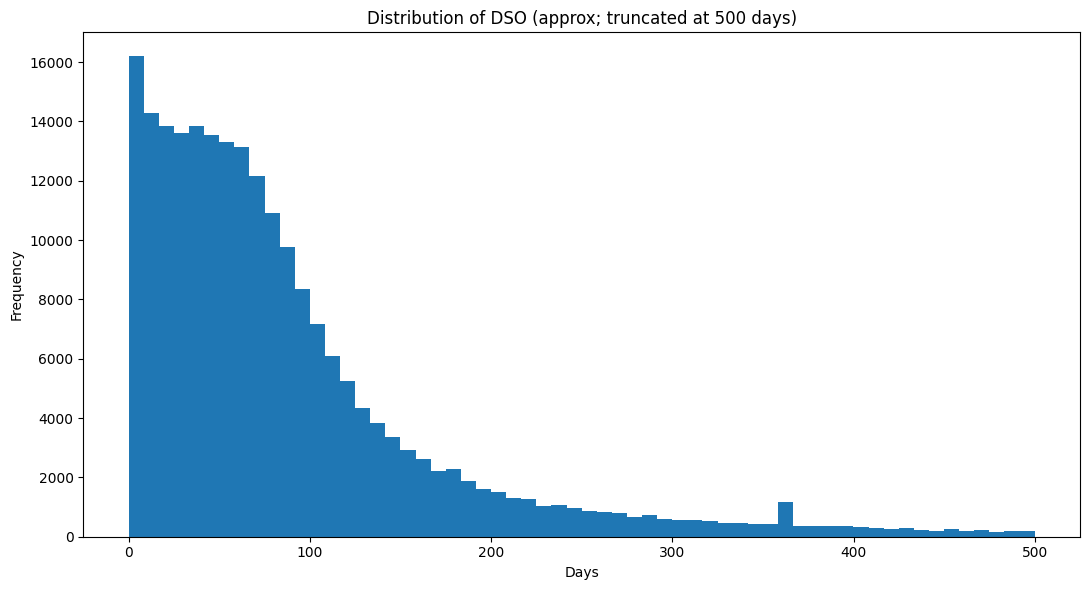

In [27]:
dso = fact["dso_approx"].replace([np.inf,-np.inf], np.nan)
dso = dso[(dso > 0) & (dso < 500)]

plt.figure(figsize=(11,6))
plt.hist(dso.dropna(), bins=60)
plt.title("Distribution of DSO (approx; truncated at 500 days)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### **D. AR Turnover by Year (Descriptive)**
#### - Shows spread of AR Turnover per year (boxplot, filtered to remove extreme outliers)

<Figure size 1200x600 with 0 Axes>

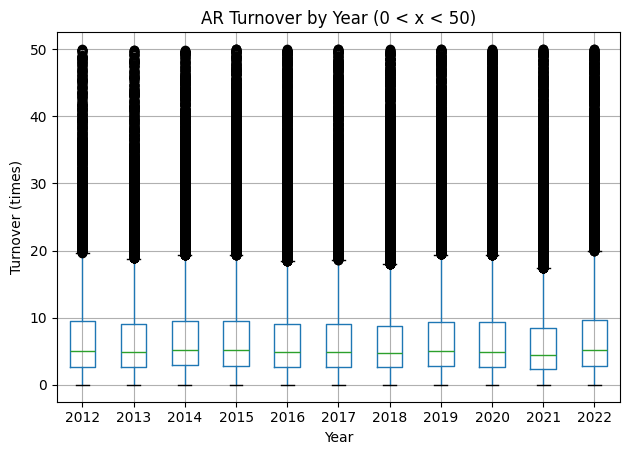

In [28]:
turn = fact["ar_turnover"].replace([np.inf,-np.inf], np.nan)
sub = fact.loc[turn.between(0, 50, inclusive="neither"), ["year","ar_turnover"]].dropna()

plt.figure(figsize=(12,6))
sub.boxplot(column="ar_turnover", by="year")
plt.suptitle("")
plt.title("AR Turnover by Year (0 < x < 50)")
plt.xlabel("Year")
plt.ylabel("Turnover (times)")
plt.tight_layout()
plt.show()

### **E. Industry × Year medians & coverage (Descriptive)**
#### - Summarizes medians and coverage by industry-year
#### - Ranks industries within the latest year by median DSO

## Industry × Year — 2022 (sorted by median DSO)

,industry_name,year,med_dso,med_ar_turnover,prov_cov,writeoff_cov,n_obs,n_companies
406,financial services,2022,287.575758,1.260052,0.036185,0.044772,3261,3261
362,publishing,2022,124.534950,2.930904,0.202381,0.333333,84,84
417,real estate services,2022,118.616881,3.077134,0.200000,0.400000,10,10
373,"video, audio broadcasting",2022,111.434002,3.275481,0.172414,0.189655,174,174
450,public administration services,2022,101.215441,3.606169,0.170732,0.121951,41,41
263,Water & waste management,2022,99.056253,3.684775,0.000000,0.111111,18,18
384,telecom services,2022,95.536152,3.820543,0.219231,0.153846,260,260
285,infra engineering,2022,91.892334,3.957079,0.115668,0.086225,951,951
439,business support services,2022,90.089263,4.053384,0.174699,0.138554,166,166
252,Utility electric power generation,2022,89.246837,4.087787,0.096229,0.036411,769,769


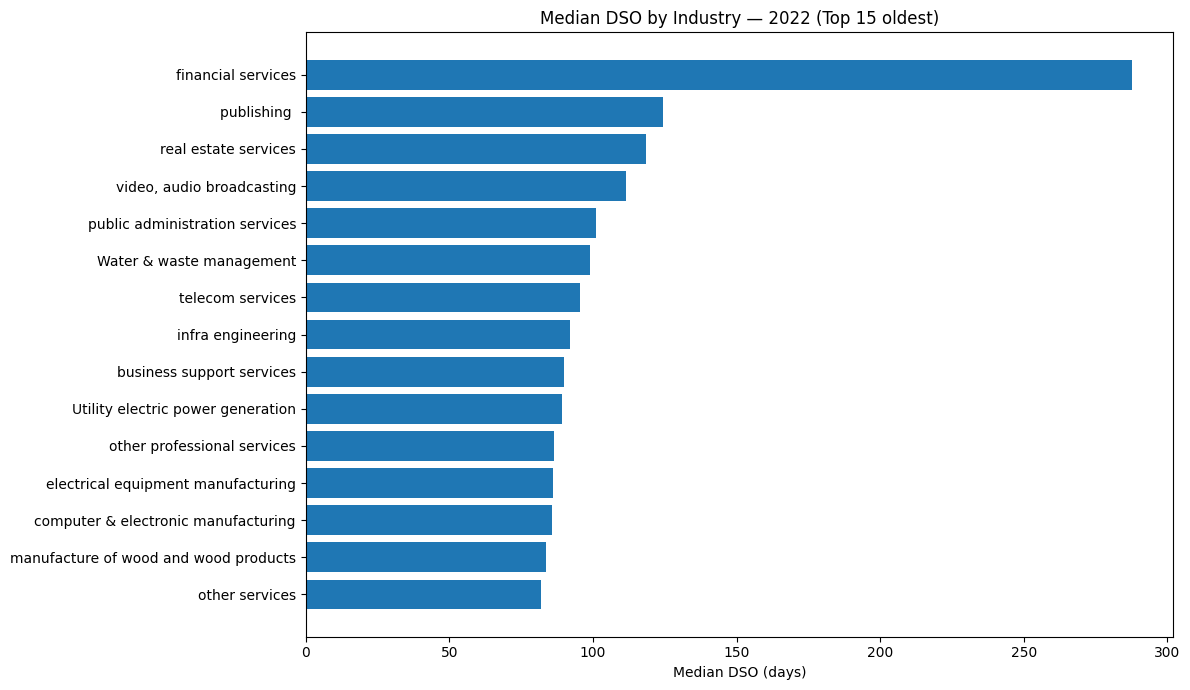

In [29]:
indyr = (fact.groupby(["industry_code","industry_name","year"], dropna=False)
            .agg(med_sales=("sales","median"),
                 med_ar=("accounts_receivables","median"),
                 med_dso=("dso_approx","median"),
                 med_ar_turnover=("ar_turnover","median"),
                 prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
                 writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
                 n_obs=("company_code","size"),
                 n_companies=("company_code","nunique"))
            .reset_index())

latest_year = int(indyr["year"].max())
top_latest = indyr[indyr["year"] == latest_year].sort_values("med_dso", ascending=False)
show_table(top_latest[["industry_name","year","med_dso","med_ar_turnover","prov_cov","writeoff_cov","n_obs","n_companies"]],
           f"Industry × Year — {latest_year} (sorted by median DSO)", rows=20)

# Quick bar of the 15 "oldest" industries (by median DSO) in latest year
plt.figure(figsize=(12,7))
plot15 = top_latest.head(15)
plt.barh(plot15["industry_name"], plot15["med_dso"])
plt.gca().invert_yaxis()
plt.title(f"Median DSO by Industry — {latest_year} (Top 15 oldest)")
plt.xlabel("Median DSO (days)")
plt.tight_layout()
plt.show()

### **F. Aging composition: % AR > 6 months (Descriptive)**
#### - Computes median share of AR aged >6m by industry (latest year)

## Median % of AR > 6 months by Industry — 2022

,med_pct_over6m,companies
industry_name,,
financial services,1.000000,3261
construction,0.884454,1350
education,0.619145,137
tobacco,0.564864,29
Water & waste management,0.564098,18
Utility electric power generation,0.517696,769
other professional services,0.437115,2334
other services,0.403802,144
healthcare services,0.359364,341


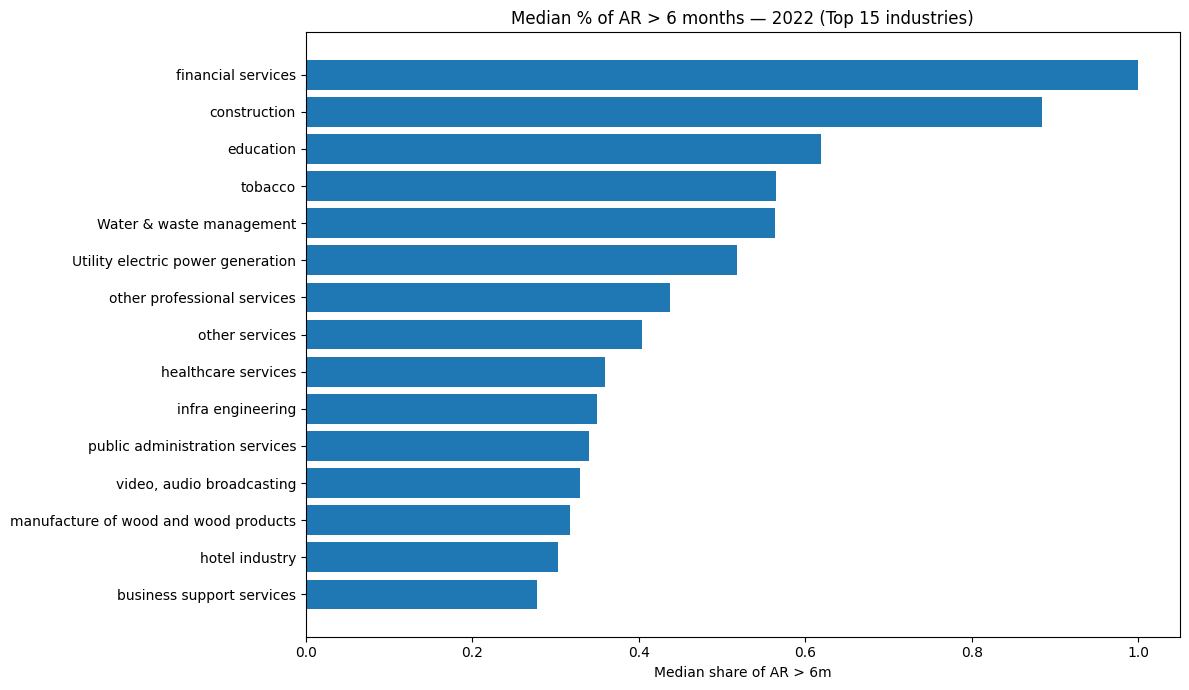

In [30]:
fact["pct_over6m"]  = fact["receivables_morethan6m"] / fact["accounts_receivables"]
comp_latest = (fact[fact["year"] == latest_year]
               .groupby("industry_name")
               .agg(med_pct_over6m=("pct_over6m","median"),
                    companies=("company_code","nunique"))
               .dropna()
               .sort_values("med_pct_over6m", ascending=False))

show_table(comp_latest, f"Median % of AR > 6 months by Industry — {latest_year}", rows=20)

plt.figure(figsize=(12,7))
plt.barh(comp_latest.head(15).index, comp_latest.head(15)["med_pct_over6m"])
plt.gca().invert_yaxis()
plt.title(f"Median % of AR > 6 months — {latest_year} (Top 15 industries)")
plt.xlabel("Median share of AR > 6m")
plt.tight_layout()
plt.show()

### **G. Diagnostic: DSO vs Provision/Write-off Rates**
#### - Buckets observations into DSO deciles
#### - Compares median provision & write-off rates across deciles

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\3298073006.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q_tbl = (df_q.groupby("dso_decile")


## DSO deciles vs median Provision/Write-off Rates

,dso_decile,n,med_dso,med_prov,med_writeoff
0,D1,998,15.408242,0.023426,0.010217
1,D2,997,33.344055,0.012252,0.005535
2,D3,997,48.590612,0.010415,0.003963
3,D4,997,61.117525,0.010036,0.004166
4,D5,998,72.560330,0.009155,0.004540
5,D6,997,84.579823,0.010359,0.004498
6,D7,997,99.652808,0.010809,0.005558
7,D8,997,119.265594,0.012348,0.006481
8,D9,997,152.160169,0.013935,0.006155
9,D10,998,228.914397,0.017129,0.006582


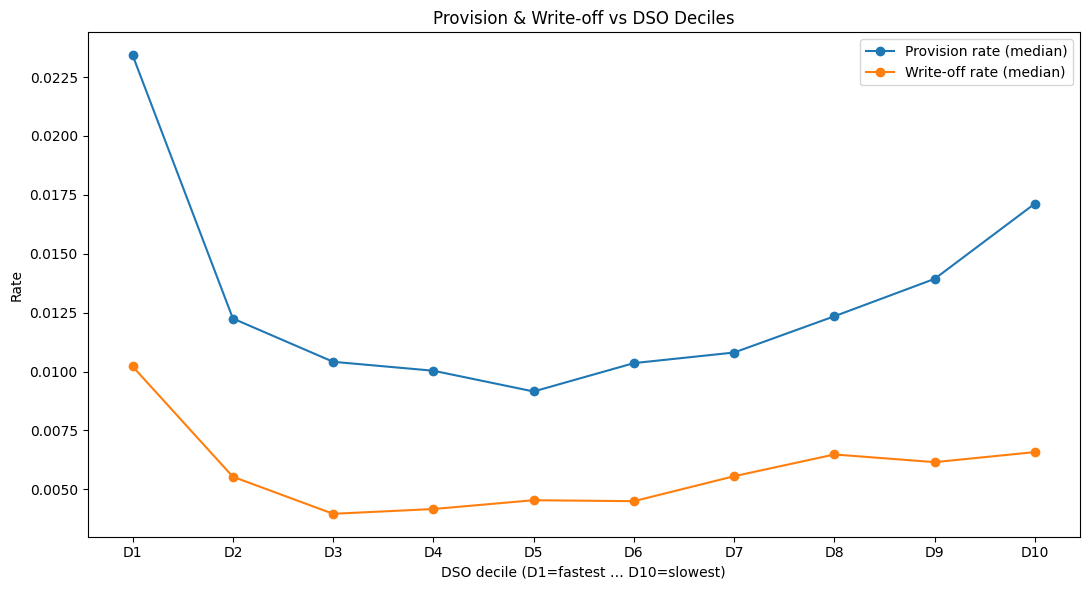

In [31]:
valid = fact["dso_approx"].between(1, 400)
df_q = fact.loc[valid, ["dso_approx","prov_rate","writeoff_rate"]].replace([np.inf,-np.inf], np.nan).dropna()
df_q["dso_decile"] = pd.qcut(df_q["dso_approx"], 10, labels=[f"D{i}" for i in range(1,11)])

q_tbl = (df_q.groupby("dso_decile")
              .agg(n=("dso_approx","size"),
                   med_dso=("dso_approx","median"),
                   med_prov=("prov_rate","median"),
                   med_writeoff=("writeoff_rate","median"))
              .reset_index()
              .sort_values("med_dso"))

show_table(q_tbl, "DSO deciles vs median Provision/Write-off Rates", rows=10)

plt.figure(figsize=(11,6))
plt.plot(q_tbl["dso_decile"].astype(str), q_tbl["med_prov"], marker="o", label="Provision rate (median)")
plt.plot(q_tbl["dso_decile"].astype(str), q_tbl["med_writeoff"], marker="o", label="Write-off rate (median)")
plt.title("Provision & Write-off vs DSO Deciles")
plt.xlabel("DSO decile (D1=fastest … D10=slowest)")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.show()

### **H. Diagnostic: NI>0 & CFO<0 vs DSO deciles and by Industry**
#### - Examines earnings quality flag across DSO deciles
#### - Ranks industries by incidence of NI>0 & CFO<0

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\3605971828.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q3a = (df_e.groupby("dso_decile")["ni_pos_cfo_neg_flag"].mean()


## Share of NI>0 & CFO<0 by DSO decile

,dso_decile,share_nipos_cfoneg
0,D1,0.128478
1,D2,0.125544
2,D3,0.122374
3,D4,0.124834
4,D5,0.126633
5,D6,0.131885
6,D7,0.141113
7,D8,0.166004
8,D9,0.180760
9,D10,0.185367


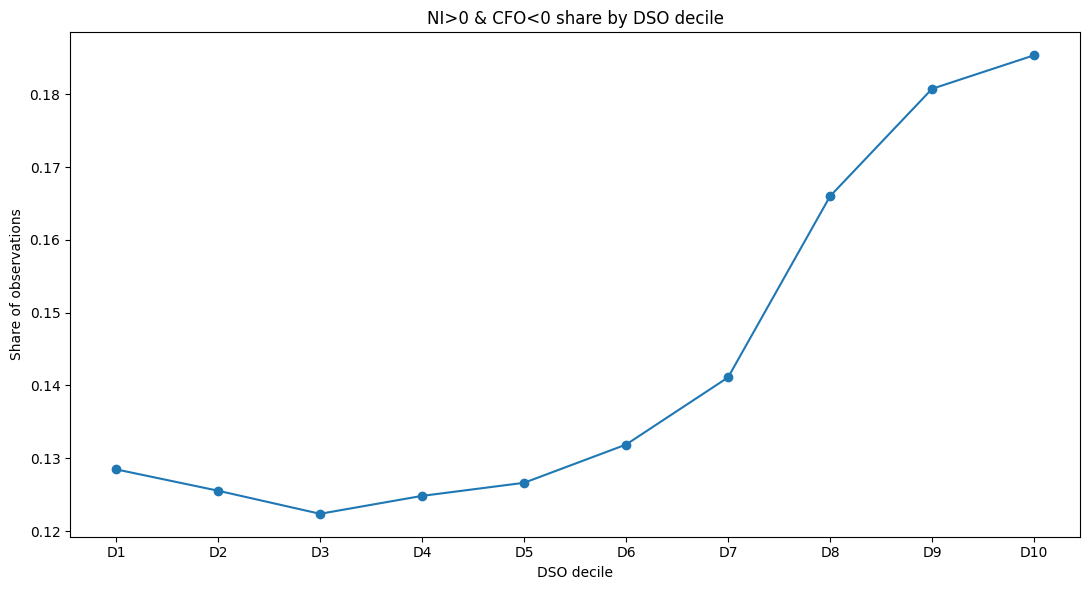

## Industries ranked by NI>0 & CFO<0 share

,industry_name,share_nipos_cfoneg
18,financial services,0.185954
6,Wholesale trading business,0.176979
8,automobile sale & service,0.163726
7,apparel industry,0.155428
0,Agriculture,0.152608
31,petroleum refinery,0.145985
16,electrical equipment manufacturing,0.141522
9,basic metals manufacturing,0.139992
2,Retail trading business,0.137650
43,"video, audio broadcasting",0.137357


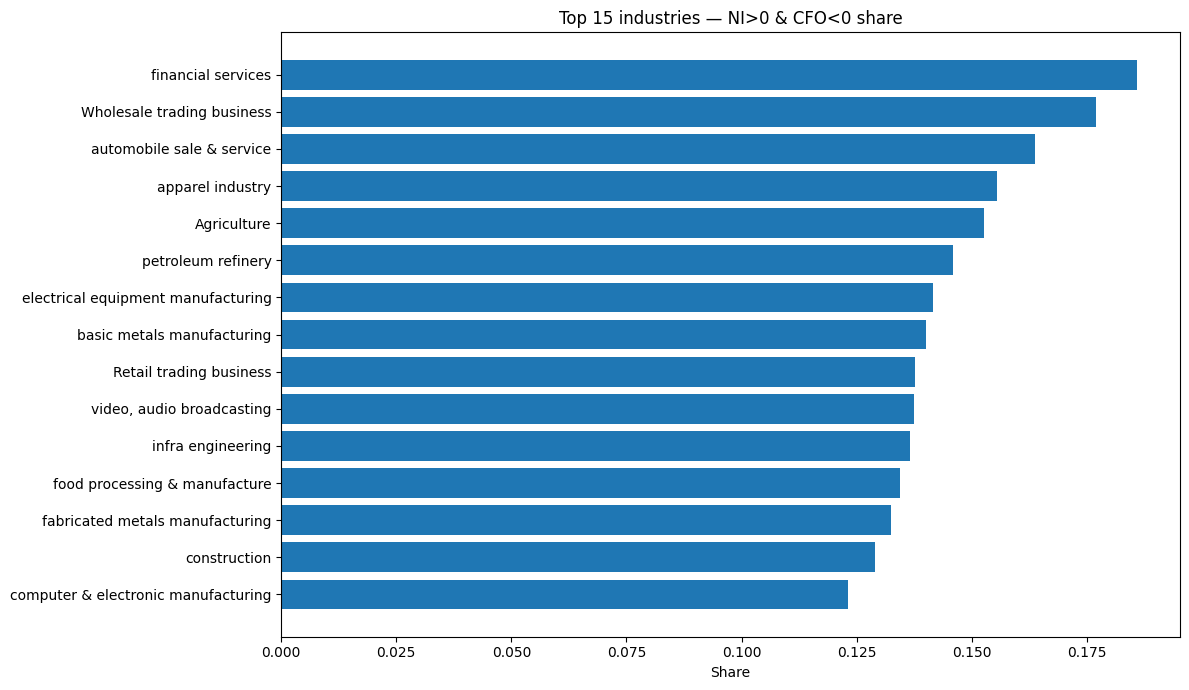

In [32]:
df_e = fact.loc[valid, ["dso_approx","ni_pos_cfo_neg_flag"]].dropna()
df_e["dso_decile"] = pd.qcut(df_e["dso_approx"], 10, labels=[f"D{i}" for i in range(1,11)])
q3a = (df_e.groupby("dso_decile")["ni_pos_cfo_neg_flag"].mean()
            .rename("share_nipos_cfoneg").reset_index())

show_table(q3a, "Share of NI>0 & CFO<0 by DSO decile", rows=10)

plt.figure(figsize=(11,6))
plt.plot(q3a["dso_decile"].astype(str), q3a["share_nipos_cfoneg"], marker="o")
plt.title("NI>0 & CFO<0 share by DSO decile")
plt.xlabel("DSO decile")
plt.ylabel("Share of observations")
plt.tight_layout()
plt.show()

by_ind = (fact.groupby("industry_name")["ni_pos_cfo_neg_flag"]
            .mean().rename("share_nipos_cfoneg").reset_index()
            .sort_values("share_nipos_cfoneg", ascending=False))

show_table(by_ind, "Industries ranked by NI>0 & CFO<0 share", rows=20)

plt.figure(figsize=(12,7))
plt.barh(by_ind.head(15)["industry_name"], by_ind.head(15)["share_nipos_cfoneg"])
plt.gca().invert_yaxis()
plt.title("Top 15 industries — NI>0 & CFO<0 share")
plt.xlabel("Share")
plt.tight_layout()
plt.show()

### **I. Diagnostic: AR composition integrity**
#### - Shows the lowest integrity pass rates by industry-year
#### - Lists companies with highest failure rates
#### - Convert ar_comp_ok to numeric {1,0} if needed

## Lowest AR composition integrity — industry-year

,industry_name,year,ar_comp_ok_rate
424,telecom services,2018,0.208904
427,telecom services,2021,0.216216
426,telecom services,2020,0.218519
425,telecom services,2019,0.219858
43,Utility electric power generation,2022,0.222609
428,telecom services,2022,0.226244
423,telecom services,2017,0.230000
42,Utility electric power generation,2021,0.238983
41,Utility electric power generation,2020,0.247078
40,Utility electric power generation,2019,0.259197


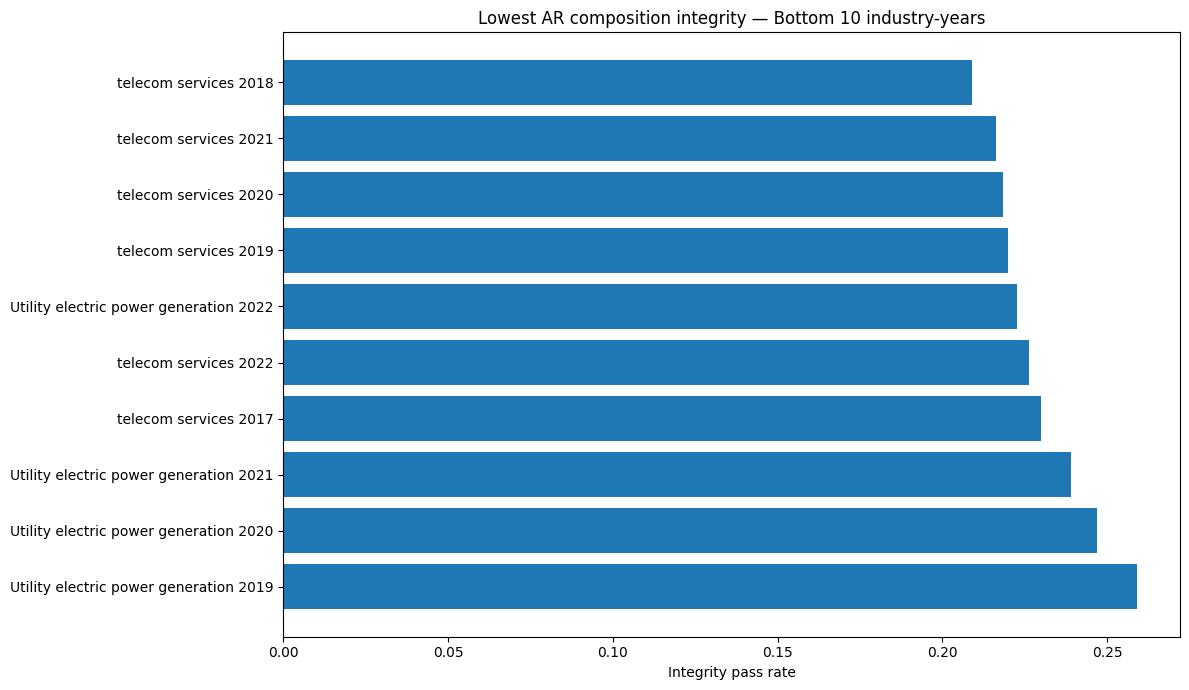

## Companies with highest AR composition failure rate

,company_code,ar_fail_rate
38643,757541,1.0
39066,787702,1.0
39065,787699,1.0
39067,787763,1.0
14443,337095,1.0
38691,759244,1.0
38688,759119,1.0
30,100612,1.0
38999,784979,1.0
14339,335965,1.0


In [33]:
ar_ok_num = pd.to_numeric(fact["ar_comp_ok"], errors="coerce")
fact["_ar_ok_num"] = ar_ok_num

indyr_int = (fact.groupby(["industry_name","year"], dropna=False)["_ar_ok_num"]
                .mean().rename("ar_comp_ok_rate").reset_index()
                .sort_values("ar_comp_ok_rate", ascending=True))

show_table(indyr_int, "Lowest AR composition integrity — industry-year", rows=15)

plt.figure(figsize=(12,7))
tmp = indyr_int.head(10)
plt.barh(tmp["industry_name"] + " " + tmp["year"].astype(int).astype(str), tmp["ar_comp_ok_rate"])
plt.gca().invert_yaxis()
plt.title("Lowest AR composition integrity — Bottom 10 industry-years")
plt.xlabel("Integrity pass rate")
plt.tight_layout()
plt.show()

comp_fail = (fact.assign(ar_fail = 1 - fact["_ar_ok_num"])
               .groupby("company_code")["ar_fail"].mean()
               .rename("ar_fail_rate").reset_index()
               .sort_values("ar_fail_rate", ascending=False))

show_table(comp_fail, "Companies with highest AR composition failure rate", rows=20)

### **J. Correlation heatmap (Key metrics)**
#### - Computes Pearson correlations among core metrics
#### - Annotates each cell with the correlation score

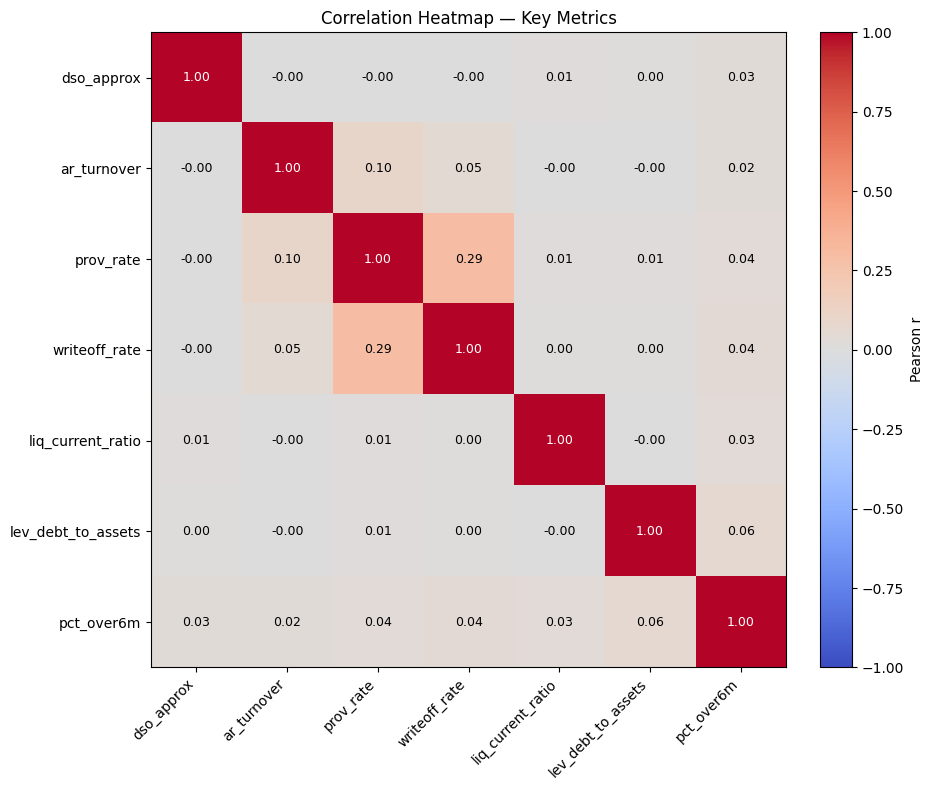

In [35]:
from matplotlib.colors import TwoSlopeNorm

corr_cols = [
    "dso_approx","ar_turnover","prov_rate","writeoff_rate",
    "liq_current_ratio","lev_debt_to_assets","pct_over6m"
]
# Ensure composition shares exist
if "pct_over6m" not in fact.columns:
    fact["pct_over6m"] = fact["receivables_morethan6m"] / fact["accounts_receivables"]

corr_df = fact[corr_cols].replace([np.inf,-np.inf], np.nan).corr(method="pearson")

plt.figure(figsize=(10,8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = plt.imshow(corr_df.values, cmap="coolwarm", norm=norm)

plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)

# Annotate with r-values
n = len(corr_cols)
for i in range(n):
    for j in range(n):
        val = float(corr_df.values[i, j])
        color = "white" if abs(val) >= 0.6 else "black"
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=color)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Pearson r")

plt.title("Correlation Heatmap — Key Metrics")
plt.tight_layout()
plt.show()

## ***IV. Analytics Questions & Answers***

### **A. Preconditions & helpers**
#### - Verifies the cleaned/merged DataFrame `fact` exists
#### - Adds small helpers for clean displays & safe binning

In [36]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'fact' in globals(), \
    "The cleaned/merged DataFrame `fact` was not found. Please run the Cleaning & Summary cells first."

def show_table(df: pd.DataFrame, title: str, rows: int = 15):
    display(Markdown(f"## {title}"))
    display(df.head(rows))

def finite(s: pd.Series):
    return s.replace([np.inf, -np.inf], np.nan)

def make_quantile_bins(s: pd.Series, q: int, labels=None):
    """
    Robust quantile binning with fallback when there are many ties.
    """
    s = pd.to_numeric(s, errors="coerce")
    try:
        return pd.qcut(s, q, labels=labels)
    except ValueError:
        # Fallback: rank-based percentiles, then cut
        r = s.rank(pct=True, method="average")
        return pd.cut(r, bins=np.linspace(0,1,q+1), include_lowest=True, labels=labels)

### **B — Q1: Which industries/years show atypical AR aging?**
#### - Computes Industry × Year medians (DSO, AR Turnover) + coverage
#### - Ranks industries by median DSO in the latest year
#### - Shows a quick bar chart of the 15 "oldest" industries

## Q1 — Industry × Year aging — 2022 (sorted by median DSO)

,industry_name,year,med_dso,med_ar_turnover,med_pct_over6m,prov_cov,writeoff_cov,n_obs,n_companies
406,financial services,2022,287.575758,1.260052,1.000000,0.036185,0.044772,3261,3261
362,publishing,2022,124.534950,2.930904,0.225624,0.202381,0.333333,84,84
417,real estate services,2022,118.616881,3.077134,0.199408,0.200000,0.400000,10,10
373,"video, audio broadcasting",2022,111.434002,3.275481,0.329989,0.172414,0.189655,174,174
450,public administration services,2022,101.215441,3.606169,0.339824,0.170732,0.121951,41,41
263,Water & waste management,2022,99.056253,3.684775,0.564098,0.000000,0.111111,18,18
384,telecom services,2022,95.536152,3.820543,0.158418,0.219231,0.153846,260,260
285,infra engineering,2022,91.892334,3.957079,0.349899,0.115668,0.086225,951,951
439,business support services,2022,90.089263,4.053384,0.277678,0.174699,0.138554,166,166
252,Utility electric power generation,2022,89.246837,4.087787,0.517696,0.096229,0.036411,769,769


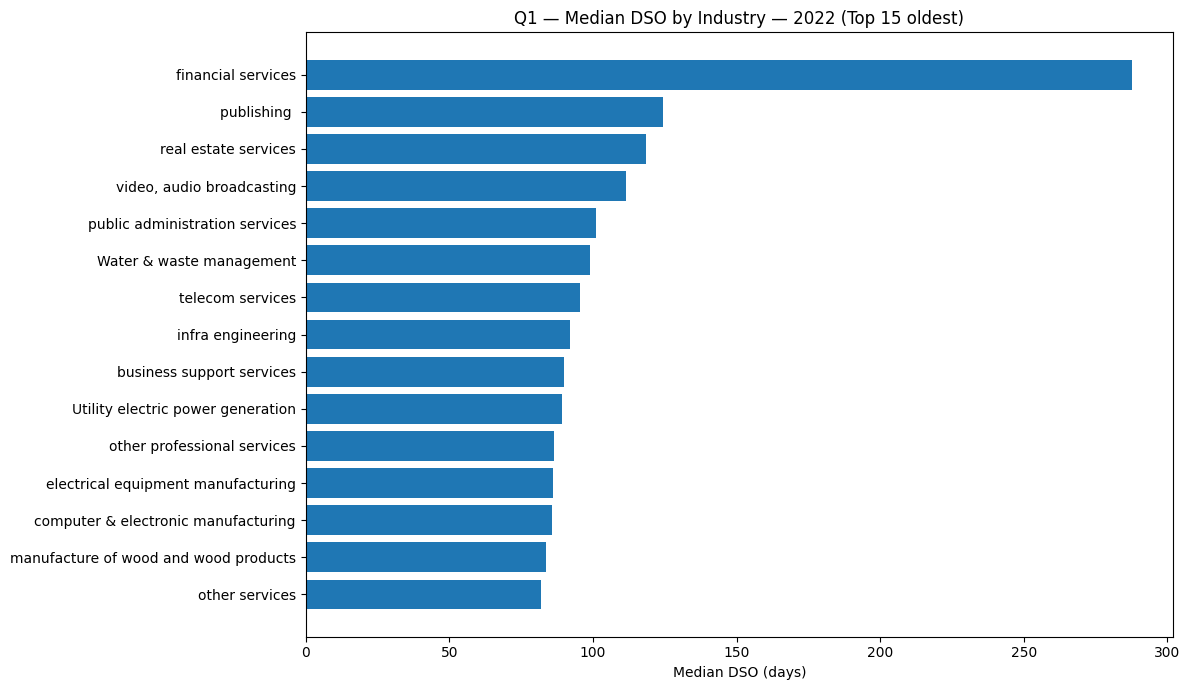

In [37]:
indyr = (fact.groupby(["industry_code","industry_name","year"], dropna=False)
           .agg(med_dso=("dso_approx","median"),
                med_ar_turnover=("ar_turnover","median"),
                med_pct_over6m=("receivables_morethan6m", lambda s: (s / fact.loc[s.index, "accounts_receivables"]).median()),
                prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
                writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
                n_obs=("company_code","size"),
                n_companies=("company_code","nunique"))
           .reset_index())

latest_year = int(indyr["year"].max())
q1_latest = indyr[indyr["year"] == latest_year].sort_values("med_dso", ascending=False)
show_table(q1_latest[["industry_name","year","med_dso","med_ar_turnover","med_pct_over6m","prov_cov","writeoff_cov","n_obs","n_companies"]],
           f"Q1 — Industry × Year aging — {latest_year} (sorted by median DSO)", rows=20)

plt.figure(figsize=(12,7))
top15 = q1_latest.head(15)
plt.barh(top15["industry_name"], top15["med_dso"])
plt.gca().invert_yaxis()
plt.title(f"Q1 — Median DSO by Industry — {latest_year} (Top 15 oldest)")
plt.xlabel("Median DSO (days)")
plt.tight_layout()
plt.show()

### **C — Q2: Do slower collections correlate with higher provisioning/write-offs?**
#### - Buckets into DSO deciles (robust to ties)
#### - Compares median provision/write-off rates across deciles
#### - Plots both lines across deciles

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\3020493521.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q2 = (df_q2.groupby("dso_decile")


## Q2 — DSO deciles vs provision & write-off (medians)

,dso_decile,n,med_dso,med_prov_rate,med_writeoff_rate
0,D1,998,15.408242,0.023426,0.010217
1,D2,997,33.344055,0.012252,0.005535
2,D3,997,48.590612,0.010415,0.003963
3,D4,997,61.117525,0.010036,0.004166
4,D5,998,72.560330,0.009155,0.004540
5,D6,997,84.579823,0.010359,0.004498
6,D7,997,99.652808,0.010809,0.005558
7,D8,997,119.265594,0.012348,0.006481
8,D9,997,152.160169,0.013935,0.006155
9,D10,998,228.914397,0.017129,0.006582


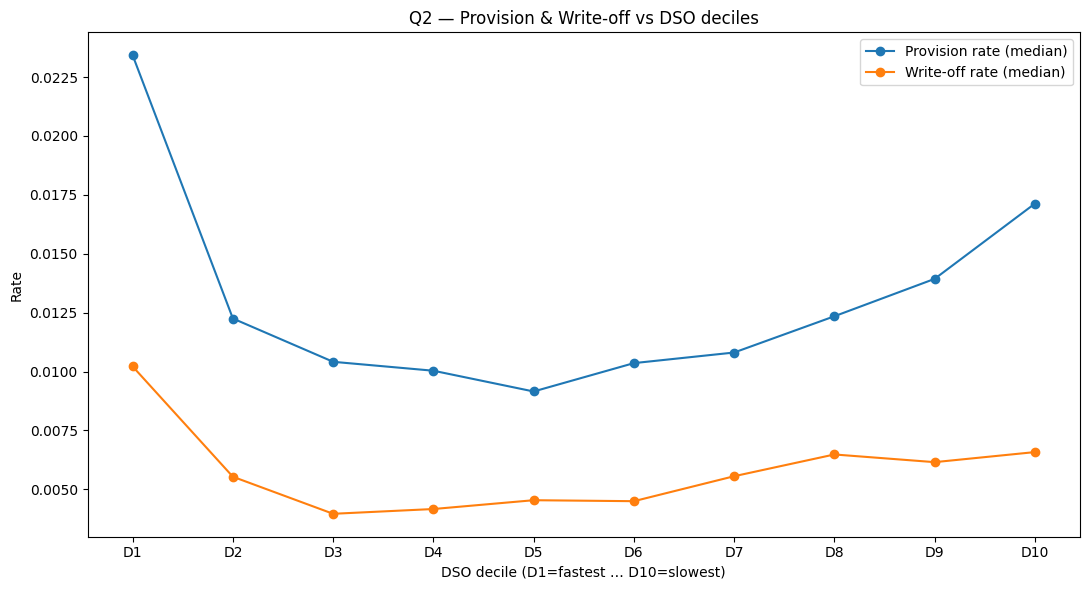

In [38]:
mask = fact["dso_approx"].between(1, 400)
df_q2 = fact.loc[mask, ["dso_approx","prov_rate","writeoff_rate"]].copy()
df_q2 = df_q2.replace([np.inf,-np.inf], np.nan).dropna()

labels = [f"D{i}" for i in range(1,11)]
df_q2["dso_decile"] = make_quantile_bins(df_q2["dso_approx"], 10, labels=labels)

q2 = (df_q2.groupby("dso_decile")
          .agg(n=("dso_approx","size"),
               med_dso=("dso_approx","median"),
               med_prov_rate=("prov_rate","median"),
               med_writeoff_rate=("writeoff_rate","median"))
          .reset_index()
          .sort_values("med_dso"))
show_table(q2, "Q2 — DSO deciles vs provision & write-off (medians)", rows=10)

plt.figure(figsize=(11,6))
plt.plot(q2["dso_decile"].astype(str), q2["med_prov_rate"], marker="o", label="Provision rate (median)")
plt.plot(q2["dso_decile"].astype(str), q2["med_writeoff_rate"], marker="o", label="Write-off rate (median)")
plt.title("Q2 — Provision & Write-off vs DSO deciles")
plt.xlabel("DSO decile (D1=fastest … D10=slowest)")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.show()

### **D — Q3: Is earnings quality weaker where collections lag?**
#### - Computes NI>0 & CFO<0 share across DSO deciles
#### - Ranks industries by that share

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\2369723017.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q3a = (df_q3.groupby("dso_decile")["ni_pos_cfo_neg_flag"]


## Q3a — NI>0 & CFO<0 share by DSO decile

,dso_decile,share_nipos_cfoneg
0,D1,0.128478
1,D2,0.125544
2,D3,0.122374
3,D4,0.124834
4,D5,0.126633
5,D6,0.131885
6,D7,0.141113
7,D8,0.166004
8,D9,0.180760
9,D10,0.185367


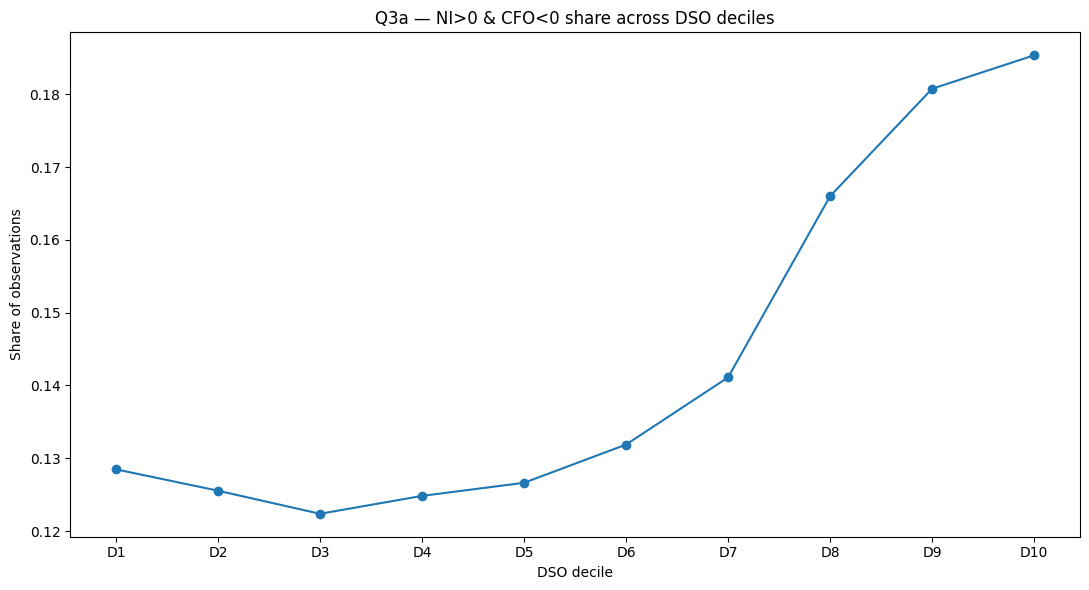

## Q3b — Industries ranked by NI>0 & CFO<0 share

,industry_name,share_nipos_cfoneg
18,financial services,0.185954
6,Wholesale trading business,0.176979
8,automobile sale & service,0.163726
7,apparel industry,0.155428
0,Agriculture,0.152608
31,petroleum refinery,0.145985
16,electrical equipment manufacturing,0.141522
9,basic metals manufacturing,0.139992
2,Retail trading business,0.137650
43,"video, audio broadcasting",0.137357


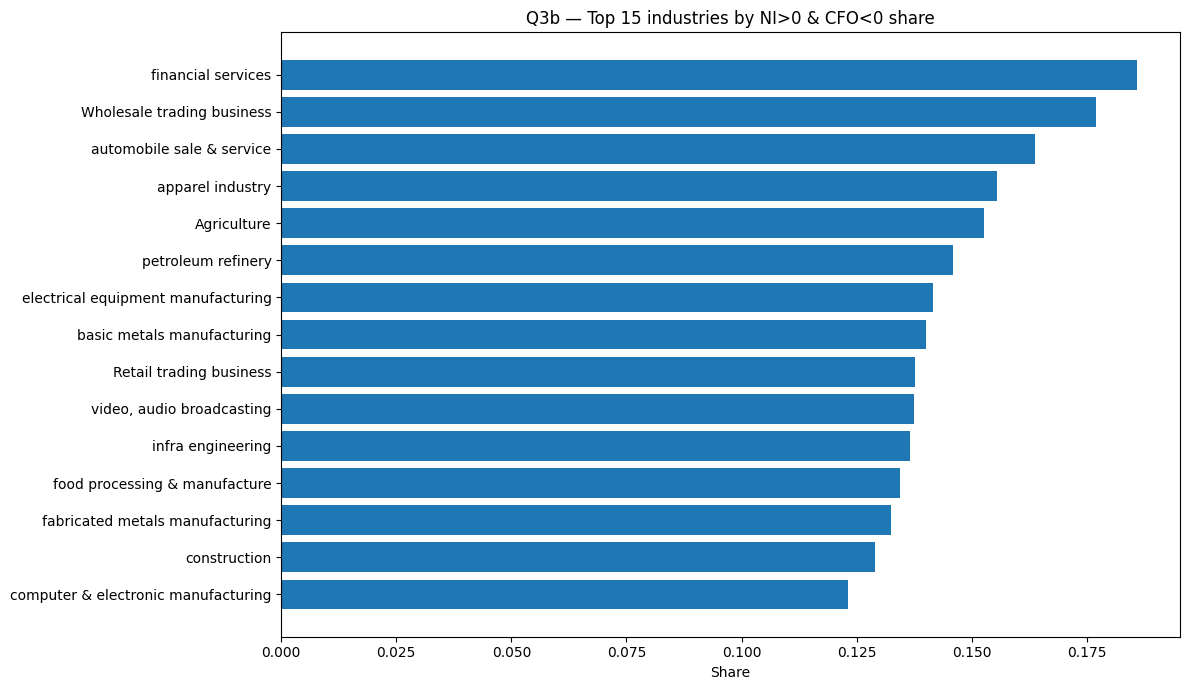

In [39]:
df_q3 = fact.loc[mask, ["dso_approx","ni_pos_cfo_neg_flag"]].dropna()
df_q3["dso_decile"] = make_quantile_bins(df_q3["dso_approx"], 10, labels=[f"D{i}" for i in range(1,11)])

q3a = (df_q3.groupby("dso_decile")["ni_pos_cfo_neg_flag"]
            .mean().rename("share_nipos_cfoneg").reset_index())
show_table(q3a, "Q3a — NI>0 & CFO<0 share by DSO decile", rows=10)

plt.figure(figsize=(11,6))
plt.plot(q3a["dso_decile"].astype(str), q3a["share_nipos_cfoneg"], marker="o")
plt.title("Q3a — NI>0 & CFO<0 share across DSO deciles")
plt.xlabel("DSO decile")
plt.ylabel("Share of observations")
plt.tight_layout()
plt.show()

by_ind = (fact.groupby("industry_name")["ni_pos_cfo_neg_flag"]
            .mean().rename("share_nipos_cfoneg").reset_index()
            .sort_values("share_nipos_cfoneg", ascending=False))
show_table(by_ind, "Q3b — Industries ranked by NI>0 & CFO<0 share", rows=20)

plt.figure(figsize=(12,7))
plt.barh(by_ind.head(15)["industry_name"], by_ind.head(15)["share_nipos_cfoneg"])
plt.gca().invert_yaxis()
plt.title("Q3b — Top 15 industries by NI>0 & CFO<0 share")
plt.xlabel("Share")
plt.tight_layout()
plt.show()

### **E — Q4: Where are AR composition integrity issues concentrated?**
#### - Shows lowest pass rates by industry-year
#### - Lists companies with the highest failure rates

## Q4a — Lowest AR composition integrity (industry-year)

,industry_name,year,ar_comp_ok_rate
424,telecom services,2018,0.208904
427,telecom services,2021,0.216216
426,telecom services,2020,0.218519
425,telecom services,2019,0.219858
43,Utility electric power generation,2022,0.222609
428,telecom services,2022,0.226244
423,telecom services,2017,0.230000
42,Utility electric power generation,2021,0.238983
41,Utility electric power generation,2020,0.247078
40,Utility electric power generation,2019,0.259197


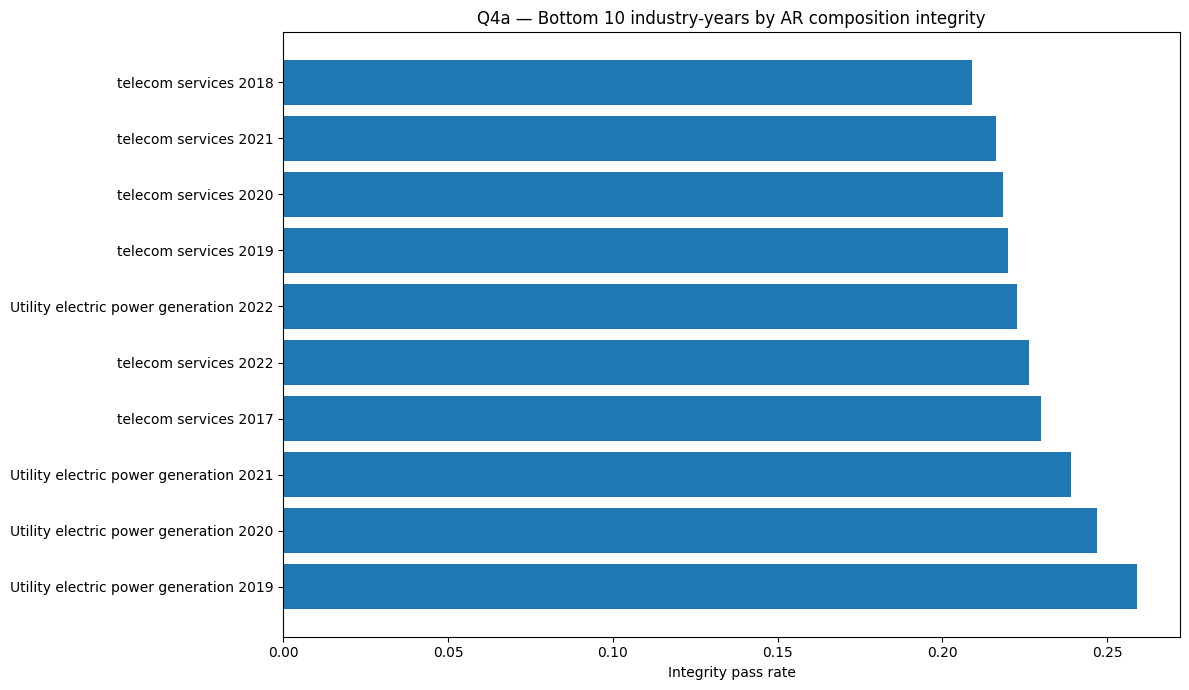

## Q4b — Companies with highest AR composition failure rate

,company_code,ar_fail_rate
38643,757541,1.0
39066,787702,1.0
39065,787699,1.0
39067,787763,1.0
14443,337095,1.0
38691,759244,1.0
38688,759119,1.0
30,100612,1.0
38999,784979,1.0
14339,335965,1.0


In [40]:
ar_ok_num = pd.to_numeric(fact["ar_comp_ok"], errors="coerce")
fact["_ar_ok_num"] = ar_ok_num

indyr_int = (fact.groupby(["industry_name","year"], dropna=False)["_ar_ok_num"]
               .mean().rename("ar_comp_ok_rate").reset_index()
               .sort_values("ar_comp_ok_rate", ascending=True))
show_table(indyr_int, "Q4a — Lowest AR composition integrity (industry-year)", rows=15)

plt.figure(figsize=(12,7))
tmp = indyr_int.head(10)
plt.barh(tmp["industry_name"] + " " + tmp["year"].astype(int).astype(str), tmp["ar_comp_ok_rate"])
plt.gca().invert_yaxis()
plt.title("Q4a — Bottom 10 industry-years by AR composition integrity")
plt.xlabel("Integrity pass rate")
plt.tight_layout()
plt.show()

comp_fail = (fact.assign(ar_fail = 1 - fact["_ar_ok_num"])
               .groupby("company_code")["ar_fail"].mean()
               .rename("ar_fail_rate").reset_index()
               .sort_values("ar_fail_rate", ascending=False))
show_table(comp_fail, "Q4b — Companies with highest AR composition failure rate", rows=20)

### **F — Q5: What are the time trends in collection efficiency?**
#### - Year-over-year medians for DSO and AR Turnover
#### - Line charts for both

## Q5 — Yearly medians: DSO & AR Turnover

,year,med_dso,med_ar_turnover,n_obs
0,2012,66.455434,5.492403,24029
1,2013,68.638333,5.316349,23520
2,2014,66.094159,5.522424,25990
3,2015,66.115182,5.517441,28955
4,2016,69.152198,5.274961,31219
5,2017,69.957712,5.212711,31712
6,2018,72.683983,5.017267,32948
7,2019,68.000999,5.363448,32771
8,2020,68.450671,5.326581,31980
9,2021,76.780437,4.750166,31311


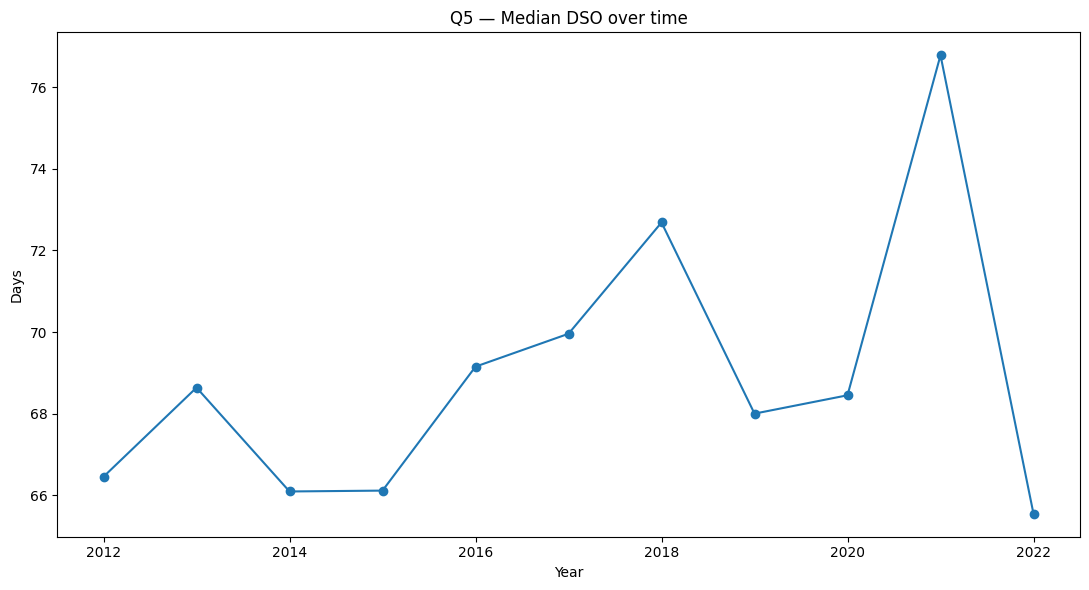

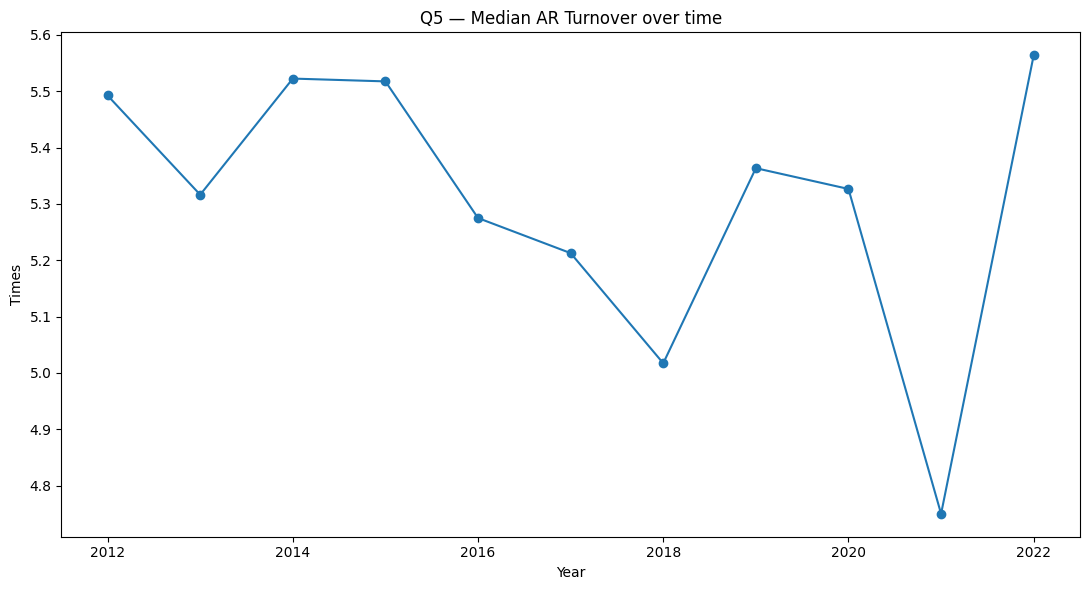

In [41]:
q5 = (fact.groupby("year", dropna=False)
        .agg(med_dso=("dso_approx","median"),
             med_ar_turnover=("ar_turnover","median"),
             n_obs=("company_code","size"))
        .reset_index()
        .sort_values("year"))
show_table(q5, "Q5 — Yearly medians: DSO & AR Turnover", rows=20)

plt.figure(figsize=(11,6))
plt.plot(q5["year"], q5["med_dso"], marker="o")
plt.title("Q5 — Median DSO over time")
plt.xlabel("Year"); plt.ylabel("Days")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(q5["year"], q5["med_ar_turnover"], marker="o")
plt.title("Q5 — Median AR Turnover over time")
plt.xlabel("Year"); plt.ylabel("Times")
plt.tight_layout()
plt.show()

### **G — Q6: How do liquidity and leverage relate to DSO?**
#### - Quartile-bins Current Ratio and Debt/Assets
#### - Compares median DSO across quartiles

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\3789694831.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q6a = (df_f.groupby("CR_quartile")


## Q6a — Median DSO by Current Ratio quartile

,CR_quartile,median_dso,n
0,CR Q1 (low),50.099290,48765
1,CR Q2,65.977136,48765
2,CR Q3,73.481046,48764
3,CR Q4 (high),79.379586,48765


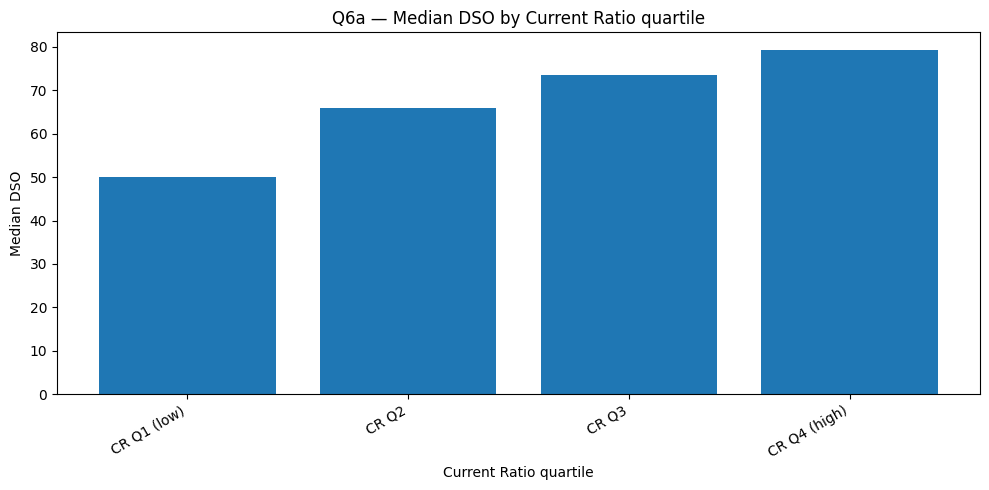

C:\Users\lilbu\AppData\Local\Temp\ipykernel_46280\3789694831.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q6b = (df_f.groupby("LEV_quartile")


## Q6b — Median DSO by Leverage (Debt/Assets) quartile

,LEV_quartile,median_dso,n
0,Lev Q1 (low),70.345947,48765
1,Lev Q2,70.332753,48765
2,Lev Q3,65.644657,48764
3,Lev Q4 (high),65.210918,48765


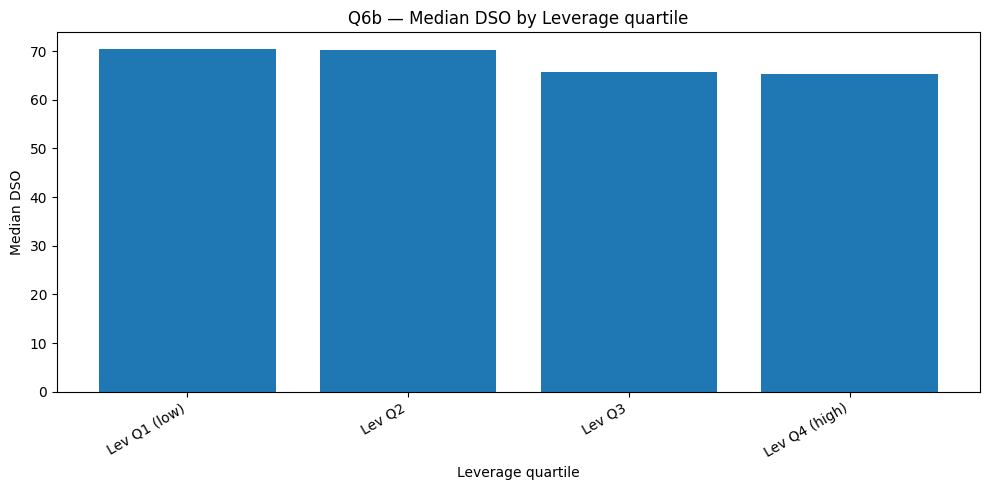

In [42]:
df_f = fact[["dso_approx","liq_current_ratio","lev_debt_to_assets"]].replace([np.inf,-np.inf], np.nan).dropna()

df_f["CR_quartile"]  = make_quantile_bins(df_f["liq_current_ratio"], 4,
                                          labels=["CR Q1 (low)","CR Q2","CR Q3","CR Q4 (high)"])
df_f["LEV_quartile"] = make_quantile_bins(df_f["lev_debt_to_assets"], 4,
                                          labels=["Lev Q1 (low)","Lev Q2","Lev Q3","Lev Q4 (high)"])

q6a = (df_f.groupby("CR_quartile")
          .agg(median_dso=("dso_approx","median"), n=("dso_approx","size"))
          .reset_index())
show_table(q6a, "Q6a — Median DSO by Current Ratio quartile", rows=10)

plt.figure(figsize=(10,5))
plt.bar(q6a["CR_quartile"].astype(str), q6a["median_dso"])
plt.title("Q6a — Median DSO by Current Ratio quartile")
plt.xlabel("Current Ratio quartile"); plt.ylabel("Median DSO")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

q6b = (df_f.groupby("LEV_quartile")
          .agg(median_dso=("dso_approx","median"), n=("dso_approx","size"))
          .reset_index())
show_table(q6b, "Q6b — Median DSO by Leverage (Debt/Assets) quartile", rows=10)

plt.figure(figsize=(10,5))
plt.bar(q6b["LEV_quartile"].astype(str), q6b["median_dso"])
plt.title("Q6b — Median DSO by Leverage quartile")
plt.xlabel("Leverage quartile"); plt.ylabel("Median DSO")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

### **H — Q7: Which industries under-report provisioning/write-offs?**
#### - Coverage by industry-year
#### - Overall worst industries by average coverage

## Q7 — Industries with lowest average provision coverage

,industry_name,avg_prov_cov,avg_writeoff_cov,years
5,Water & waste management,0.023522,0.051489,11
14,construction,0.035160,0.036254,11
18,financial services,0.045602,0.061473,11
3,Utility electric power generation,0.075678,0.060754,11
26,manufacture of paper and paper products,0.078778,0.149671,11
28,other manufacturing,0.080749,0.105170,11
17,fabricated metals manufacturing,0.082287,0.162093,11
39,textile manufacturing,0.083246,0.122241,11
0,Agriculture,0.085567,0.111463,11
6,Wholesale trading business,0.086539,0.136316,11


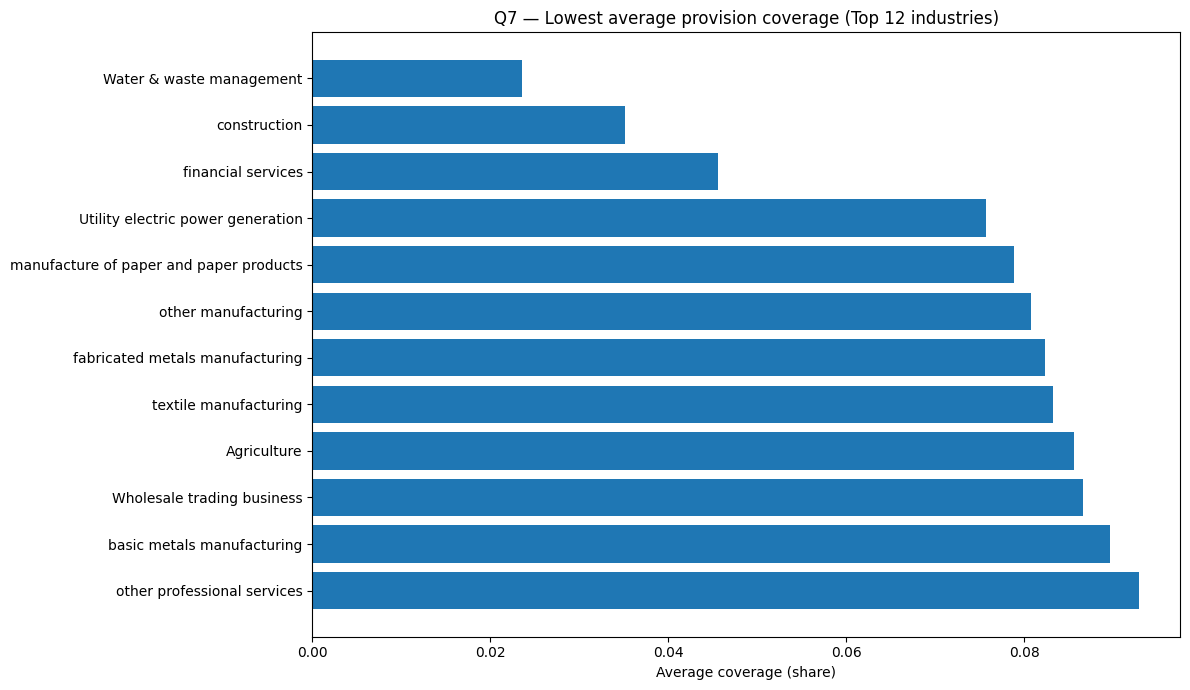

In [43]:
q7 = (fact.groupby(["industry_name","year"], dropna=False)
        .agg(prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
             writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
             n_obs=("company_code","size"))
        .reset_index())

q7b = (q7.groupby("industry_name")
         .agg(avg_prov_cov=("prov_cov","mean"),
              avg_writeoff_cov=("writeoff_cov","mean"),
              years=("year","nunique"))
         .reset_index()
         .sort_values("avg_prov_cov"))
show_table(q7b, "Q7 — Industries with lowest average provision coverage", rows=20)

plt.figure(figsize=(12,7))
plt.barh(q7b.head(12)["industry_name"], q7b.head(12)["avg_prov_cov"])
plt.gca().invert_yaxis()
plt.title("Q7 — Lowest average provision coverage (Top 12 industries)")
plt.xlabel("Average coverage (share)")
plt.tight_layout()
plt.show()

### **I — Q8: Who are standout fast/slow collectors in the latest year?**
#### - Lists 20 fastest and 20 slowest companies (median DSO) in the latest year, per industry mix
#### - Also shows a DSO histogram for the latest year

## Q8 — 2022: Fastest collectors (lowest median DSO)

,industry_name,company_code,dso_approx
5011,Wholesale trading business,703764,0.004185
10080,financial services,346629,0.006990
3091,Wholesale trading business,347260,0.007052
823,Retail trading business,685212,0.009308
4268,Wholesale trading business,634816,0.009546
10409,food processing & manufacture,201942,0.011063
5113,Wholesale trading business,709119,0.011343
14112,other manufacturing,496517,0.012442
2277,Wholesale trading business,186688,0.013086
18673,textile manufacturing,486802,0.013292


## Q8 — 2022: Slowest collectors (highest median DSO)

,industry_name,company_code,dso_approx
1784,Warehousing & storage,663925,399.975430
19174,vehicle manufacturing,124094,399.856830
2278,Wholesale trading business,186732,399.796282
930,Utility electric power generation,165551,399.350052
12289,infra engineering,486698,398.975961
3115,Wholesale trading business,349774,398.968978
915,Utility electric power generation,134786,398.443918
15086,other professional services,515514,398.247525
18945,transportation,329195,397.837370
8026,chemicals,665863,397.837370


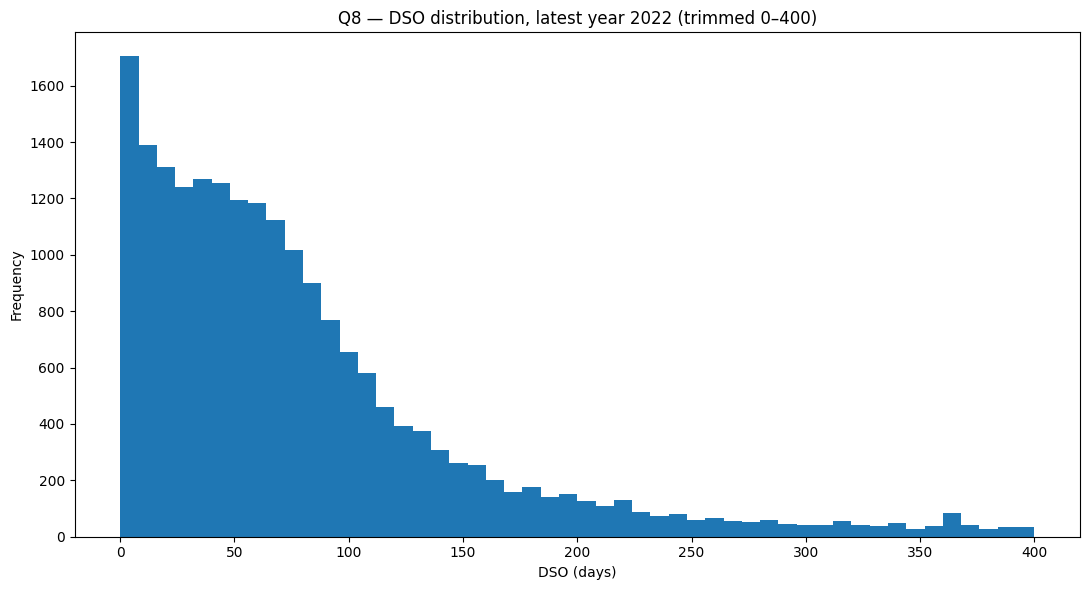

In [44]:
latest_year = int(fact["year"].max())
df_latest = fact[fact["year"] == latest_year].copy()

mask_latest = (df_latest["dso_approx"] > 0) & (df_latest["dso_approx"] < 400)
fast = (df_latest.loc[mask_latest]
        .groupby(["industry_name","company_code"])["dso_approx"]
        .median().reset_index().sort_values("dso_approx").head(20))
slow = (df_latest.loc[mask_latest]
        .groupby(["industry_name","company_code"])["dso_approx"]
        .median().reset_index().sort_values("dso_approx", ascending=False).head(20))

show_table(fast, f"Q8 — {latest_year}: Fastest collectors (lowest median DSO)", rows=20)
show_table(slow, f"Q8 — {latest_year}: Slowest collectors (highest median DSO)", rows=20)

plt.figure(figsize=(11,6))
plt.hist(df_latest.loc[mask_latest,"dso_approx"].dropna(), bins=50)
plt.title(f"Q8 — DSO distribution, latest year {latest_year} (trimmed 0–400)")
plt.xlabel("DSO (days)"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()